In [1]:
#импортируем все необходимые библиотеки
RANDOM_SEED = 42
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 100)
import re
import os
import sys
from ast import literal_eval

        
#подготовка к обучению
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler)
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder)

#ML
from sklearn import linear_model
from sklearn.linear_model import (LinearRegression, SGDRegressor)
#from sklearn.linear_model import (Lasso, Ridge, ElasticNet)
#from sklearn.linear_model import (LassoCV, RidgeCV, ElasticNetCV)
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor)
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import (KNeighborsRegressor, RadiusNeighborsRegressor)
from sklearn.tree import DecisionTreeRegressor
#from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import RandomizedSearchCV

import xgboost
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna

#метрики
from sklearn.metrics import (mean_squared_error, mean_absolute_error)
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import lightgbm as lgm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#Нейронная сеть
import keras 
from keras import models as M
from keras import layers as L
from keras import backend as K
from keras import optimizers
from keras import initializers
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Seaborn      :', sns.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['my-mod-res', 'private-dataset-app-price-predictions']
Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Pandas       : 1.2.4
Seaborn      : 0.11.1
Tensorflow   : 2.4.1
Keras        : 2.4.0


# К вам обратился представитель крупного агентства недвижимости со следующей проблемой:

## Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивает до уровня конкурентов. А это сказывается на наших финансовых показателях. Твоя задача — разработать модель, которая бы позволила обойти конкурентов по скорости и качеству совершения сделок. Датасет прикладываю.

## Итак, ваша задача: разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.  

## Выпишем полезные функции 

In [2]:
'''Информация по фиче'''
def show_info(col):
    print('Сколько пропусков? {}'.format(col.isna().sum()))
    print()
    print('Процент пропусков? {}%'.format((col.isna().sum() /len(col)) *100))
    print()      
    print('Описание:\n{}'.format(col.describe()))
    print()
    print('Как распределено?\n{}'.format(col.value_counts(dropna=False)))
    print()
    print('Какие значения?\n{}'.format(col.unique()))
    print()
    print('Сколько уникальных?\n{}'.format(col.nunique(dropna=False)))

'''Информация по фиче с гистограммой'''
def show_info_hist(col):
    print('Сколько пропусков? {}'.format(col.isna().sum()))
    print()
    print('Процент пропусков? {}%'.format((col.isna().sum() /len(col)) *100))
    print() 
    print('Описание:\n{}'.format(col.describe()))
    print()
    print('Как распределено?\n{}'.format(col.value_counts(dropna=False)))
    print()
    print('Какие значения?\n{}'.format(col.unique()))
    print()
    print('Сколько уникальных?\n{}'.format(col.nunique(dropna=False)))
    print()
    plt.figure(figsize=(15,6))
    sns.countplot(x=col, data=data)
    plt.xticks(rotation = 'vertical')
    plt.show()
    
'''Еще одна визуализация'''    
def show_plot(col):
    plt.figure(figsize=(15,6))
    col.value_counts().plot(kind='bar', color='blue')
    for i,val in enumerate(col.value_counts()):
        plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'size':12})
    plt.show()
    
    
'''Вывод метрики'''
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean())    

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Подгрузим файлы и посмотрим на данные

In [3]:
data = pd.read_csv('/kaggle/input/private-dataset-app-price-predictions/data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
data.columns

Index(['status', 'private pool', 'propertyType', 'street', 'baths',
       'homeFacts', 'fireplace', 'city', 'schools', 'sqft', 'zipcode', 'beds',
       'state', 'stories', 'mls-id', 'PrivatePool', 'MlsId', 'target'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [6]:
data.describe()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
count,337267,4181,342452,377183,270847,377185,103115,377151,377185,336608,377185,285903,377185,226470,24942,40311,310305,374704
unique,159,1,1280,337076,229,321009,1653,2026,297365,25405,4549,1184,39,348,24907,2,232944,43939
top,for sale,Yes,single-family home,Address Not Disclosed,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Houston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32137,3 Beds,FL,1.0,No,yes,NO MLS,"$225,000"
freq,156104,4181,92206,672,52466,7174,50356,24442,4204,11854,2141,53459,115449,67454,3,28793,24,1462


In [7]:
#data.describe(include = 'object')

## Посмотрим на пропуски 

In [8]:
data.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

Видим, что пропусков довольно много. Часть из них мы сможем заполнить на основе данных из таблицы, но с некоторыми "фичами", вероятно, придется попрощаться

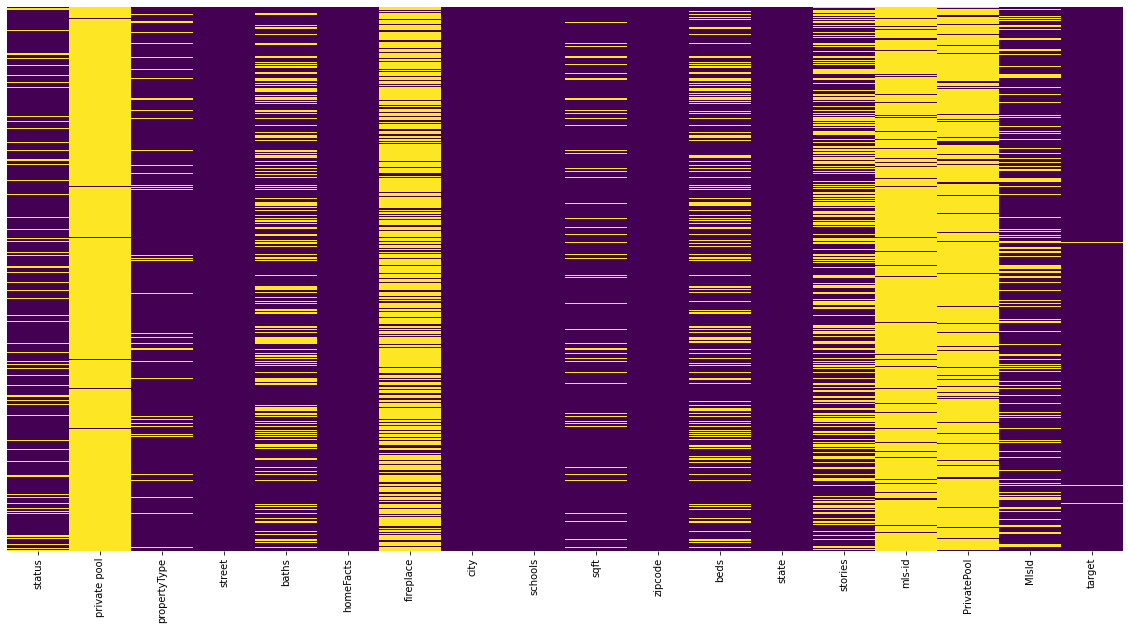

In [9]:
fig, ax = plt.subplots(figsize=(20,10))
sns_heatmap=sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
problematic_cols = []
problematic_cols += ['private pool','fireplace','baths','stories','mls-id','PrivatePool']

In [11]:
'''Создадим словарь, в который будем помещать результаты измышлений над той или иной колонков, в конце оценим результаты'''
data_dict = {}

# Постановка задачи

* Задача: предсказать стоимость дома.
* Проблематика: решение задачи регрессии.
* Метрики: MSE, MAE, RMSE, MAPE
* Оценка модели: r2

In [12]:
'''Удалим пустые строки в таргете, чтобы не вносить погрешностей от себя'''
data.drop_duplicates(inplace=True)
data.drop(data[data.target.isna()].index, inplace=True)
data.shape

(374655, 18)

# EDA

# status 

In [13]:
show_info(data['status'])

Сколько пропусков? 39256

Процент пропусков? 10.477906340499926%

Описание:
count       335399
unique         156
top       for sale
freq        156054
Name: status, dtype: object

Как распределено?
for sale                     156054
Active                       105206
For sale                      43464
NaN                           39256
foreclosure                    5677
                              ...  
Coming soon: Nov 23.              1
Coming soon: Dec 15.              1
Coming soon: Dec 23.              1
Lease/Purchase                    1
Pending, Continue to Show         1
Name: status, Length: 157, dtype: int64

Какие значения?
['Active' 'for sale' nan 'New construction' 'New' 'For sale' 'Pending' 'P'
 'Active/Contingent' ' / auction' 'Under Contract'
 'Pre-foreclosure / auction' 'Under Contract   Showing' 'Pre-foreclosure'
 'Under Contract Backups' 'Active Under Contract' 'foreclosure'
 'Foreclosed' 'Option Pending' 'Under Contract Show' 'for rent' 'Auction'
 'A Active

#### Присутствует самое популярное значение "for sale", также есть похожие паттерны "Coming soon: ...". Это позволит заменить пропуски и в дальнейшем создать новую фичу на основе выделения общих паттернов и перегруппировки различных значений 

In [14]:
data['status'] = data['status'].apply(lambda x: str(x).lower())
data['status'].value_counts().head(20)

for sale                     199520
active                       105206
nan                           39256
foreclosure                    6020
new construction               5458
pending                        4802
pre-foreclosure                2000
p                              1488
pre-foreclosure / auction      1281
under contract show            1183
 / auction                      799
under contract   showing        793
active under contract           718
under contract                  692
new                             690
contingent                      581
price change                    563
auction                         493
a active                        443
for rent                        398
Name: status, dtype: int64

In [15]:
%%time

'''Напишем функцию, которая присваивает определенные значения строке по условию'''
def change_status(status):
    if status == 'for sale': return 'for sale'
    elif 'active' in status: return 'active'
    elif 'foreclosure' in status: return 'pre foreclosure'
    elif 'pending' in status: return 'pending'
    elif status == 'nan': return 'No info'
    else: 
        return status
    
data['status_rating'] = data['status'].apply(lambda x: change_status(x))
data['status_rating'].value_counts().head(10)

CPU times: user 216 ms, sys: 0 ns, total: 216 ms
Wall time: 215 ms


for sale                    199520
active                      106554
No info                      39256
pre foreclosure               9303
new construction              5458
pending                       5359
p                             1488
under contract show           1183
 / auction                     799
under contract   showing       793
Name: status_rating, dtype: int64

In [16]:
statuses = list(data['status_rating'].value_counts()[:6].keys())
statuses

['for sale',
 'active',
 'No info',
 'pre foreclosure',
 'new construction',
 'pending']

In [17]:
def mod_status(status):
    if status in statuses:
        return status
    else: 
        return 'Other'
    
data['status_rating'] = data['status_rating'].apply(lambda x: mod_status(x))    

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count       374655
unique           7
top       for sale
freq        199520
Name: status_rating, dtype: object

Как распределено?
for sale            199520
active              106554
No info              39256
pre foreclosure       9303
Other                 9205
new construction      5458
pending               5359
Name: status_rating, dtype: int64

Какие значения?
['active' 'for sale' 'No info' 'new construction' 'Other' 'pending'
 'pre foreclosure']

Сколько уникальных?
7



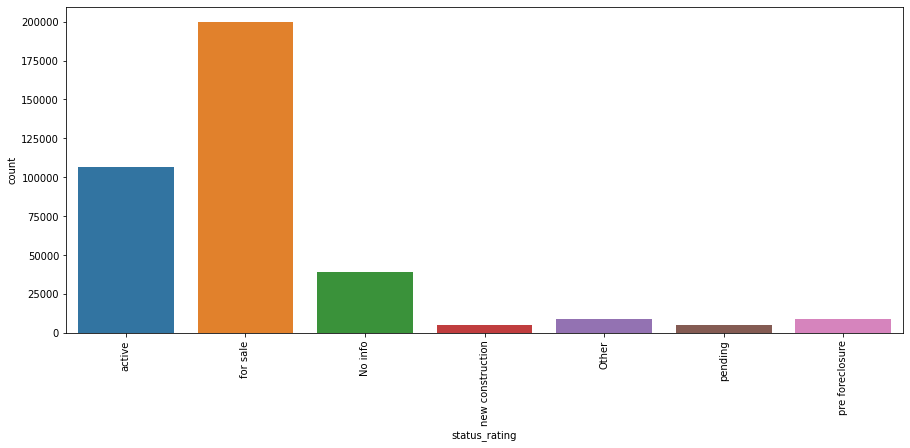

In [18]:
show_info_hist(data['status_rating'])

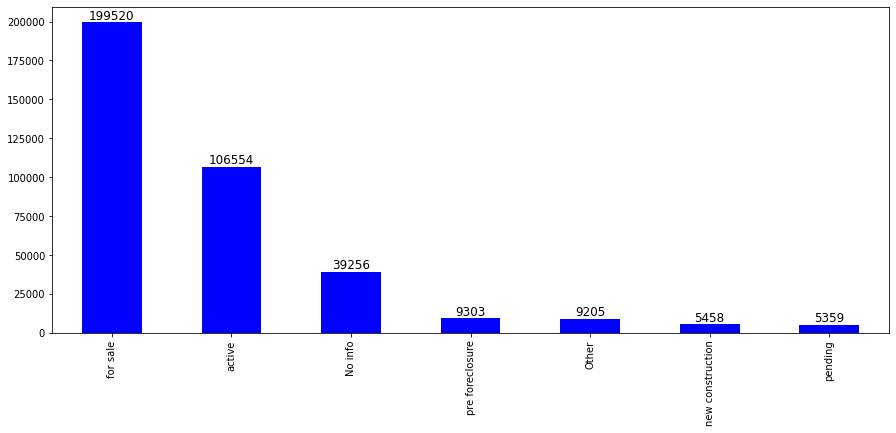

In [19]:
show_plot(data['status_rating'])

In [20]:
data_dict['status'] = 'Статус обработан, за дальнейшей ненадобностью УДАЛИМ'
data_dict['status_rating'] = 'Перевести в КАТЕГОРИИ'

# private pool

In [21]:
show_info(data['private pool'])

Сколько пропусков? 370504

Процент пропусков? 98.89204735022888%

Описание:
count     4151
unique       1
top        Yes
freq      4151
Name: private pool, dtype: object

Как распределено?
NaN    370504
Yes      4151
Name: private pool, dtype: int64

Какие значения?
[nan 'Yes']

Сколько уникальных?
2


In [22]:
# def compare(x):
#     if (x in data['private pool']) and (x in data['PrivatePool']):
#         return 1
#     elif (x in data['private pool']) and (x not in data['PrivatePool']):
#         return 2
#     elif (x not in data['private pool']) and (x in data['PrivatePool']):
#         return 3
#     else:
#         return 4
    
# data['compared_pools'] = data['private pool'].apply(compare)
# data['compared_pools'].value_counts()

In [23]:
data_dict['private pool'] = 'Слишком много пропусков, неинформативно, необходимо УДАЛИТЬ'

#### Слишком большое количество пропусков. Вижу 2 пути: удалить данную колонку или: расценить NaN как отсутсвие информации, а любой ответ - как наличие информации (однако все равно получится слишком разбалансированная колонка. Отношение NaN к Yes 89:1). Лучше удалим.

# propertyType

In [24]:
show_info(data['propertyType'])

Сколько пропусков? 34554

Процент пропусков? 9.222885054249911%

Описание:
count                 340101
unique                  1279
top       single-family home
freq                   91370
Name: propertyType, dtype: object

Как распределено?
single-family home                                               91370
Single Family                                                    61886
NaN                                                              34554
Single Family Home                                               31725
condo                                                            25874
                                                                 ...  
1 Story, Contemporary, Ranch, Traditional, Texas Hill Country        1
Condo/Townhome, Contemporary/Modern, Mediterranean, Spanish          1
Multi-Level, Tudor                                                   1
Side-by-Side, Traditional                                            1
Condo/Townhome, Single Detached, Split Level, 

In [25]:
#Посмотрим топ самых частовстречающихся значений
data['propertyType'].value_counts(dropna=False).head(30)

single-family home               91370
Single Family                    61886
NaN                              34554
Single Family Home               31725
condo                            25874
lot/land                         20506
Condo                            16494
townhouse                        11435
Land                             10933
multi-family                      7874
Condo/Townhome/Row Home/Co-Op     7701
Townhouse                         6909
Traditional                       5912
coop                              3264
Multi Family                      2771
High Rise                         1823
Ranch                             1781
Detached, One Story               1614
mobile/manufactured               1613
Single Detached, Traditional      1581
Contemporary                      1556
Multi-Family Home                 1501
1 Story                           1234
Colonial                          1204
Mobile / Manufactured             1056
Contemporary/Modern      

In [26]:
data['propertyType'] = data['propertyType'].apply(lambda x: str(x).lower())  #Привели к нижнему регистру

In [27]:
%%time

#Напишем функцию, которая создаст определенные категории из колонки.

def change_property(prop):
    if prop == 'condo': return 'condo'
    elif prop == 'land': return 'land'
    elif 'family' in prop: return 'family'
    elif prop == 'nan': return 'no info'
    else: return 'Other'
    
data['property_rating'] = data['propertyType'].apply(lambda x: change_property(x))
data.head()

CPU times: user 158 ms, sys: 1.03 ms, total: 159 ms
Wall time: 158 ms


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating
0,active,NaN,single family home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000",active,family
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000",for sale,family
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000",for sale,family
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000",for sale,family
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000",for sale,Other


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique         5
top       family
freq      197329
Name: property_rating, dtype: object

Как распределено?
family     197329
Other       89471
condo       42368
no info     34554
land        10933
Name: property_rating, dtype: int64

Какие значения?
['family' 'Other' 'no info' 'condo' 'land']

Сколько уникальных?
5



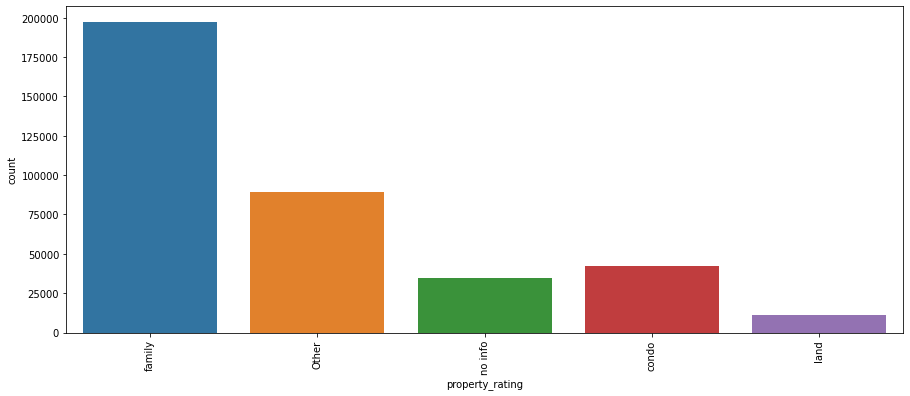

In [28]:
show_info_hist(data['property_rating'])

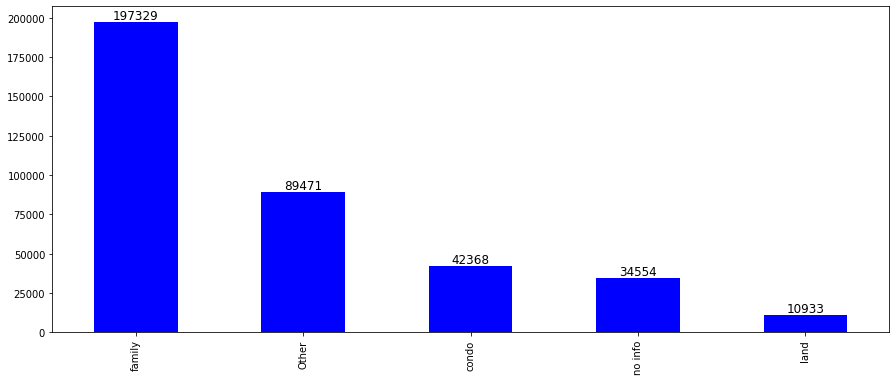

In [29]:
show_plot(data['property_rating'])

In [30]:
data_dict['propertyType'] = 'Обработал, за ненадобностью дальше УДАЛИТЬ'
data_dict['property_rating'] = 'Загнать в КАТЕГOРИИ'

In [31]:
#Создадим новую колонку, в которой подсчитаем кол-во слов в исходнйо колонке.
#Для этого сначала заменим все разделительные символы на ',' ,затем разделим по запятой и посчитаем значения  

data['num_prop_descr'] = data['propertyType'].apply(lambda x: str(
    x).replace('/', ',').replace(', ', ',').replace('-', ',').replace(' ',','))
data['num_prop_descr'] = data['num_prop_descr'].apply(lambda x: len(str(x).split(',')))

In [32]:
data['num_prop_descr'].value_counts()

3     133233
1     125031
2     105899
6       7946
4       1481
5        824
7        147
8         50
9         16
10        11
11         7
13         5
14         2
12         1
15         1
19         1
Name: num_prop_descr, dtype: int64

In [33]:
#Напишем функцию, которая возвращает категорию, к которой отнесем значение строки

def num_prop_to_cat(prop):
    if prop == 3: return '3'
    elif prop == 2: return '2'
    elif prop == 1: return '1'
    else: return '4 or more'
    
data['num_prop_descr'] = data['num_prop_descr'].apply(lambda x: num_prop_to_cat(x))

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique         4
top            3
freq      133233
Name: num_prop_descr, dtype: object

Как распределено?
3            133233
1            125031
2            105899
4 or more     10492
Name: num_prop_descr, dtype: int64

Какие значения?
['3' '2' '1' '4 or more']

Сколько уникальных?
4



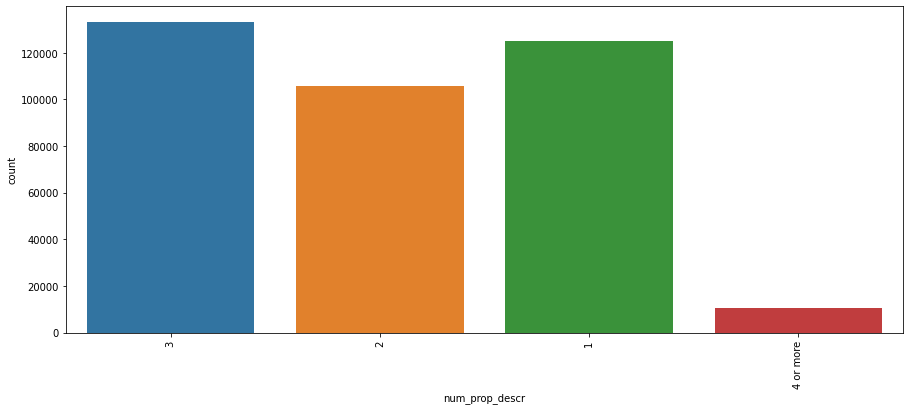

In [34]:
show_info_hist(data['num_prop_descr'])

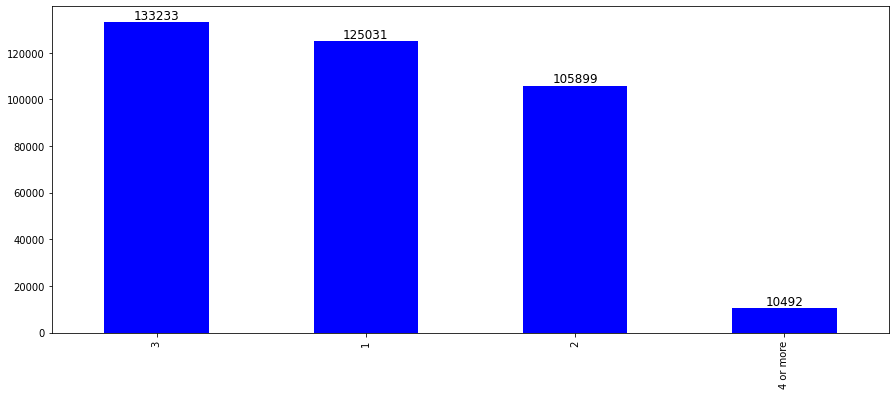

In [35]:
show_plot(data['num_prop_descr'])

In [36]:
data_dict['num_prop_descr'] = 'Перевести в КАТЕГОРИИ'

# street 

In [37]:
show_info(data['street'])

Сколько пропусков? 2

Процент пропусков? 0.0005338244518290161%

Описание:
count                    374653
unique                   334751
top       Address Not Disclosed
freq                        672
Name: street, dtype: object

Как распределено?
Address Not Disclosed      672
Undisclosed Address        516
(undisclosed Address)      391
Address Not Available      175
Unknown Address             72
                          ... 
26942 White Plains Way       1
300 Bayview Dr APT 1108      1
10105 McCree Rd              1
11804 NE 11th Ave            1
2320 Bell Blvd #2H           1
Name: street, Length: 334752, dtype: int64

Какие значения?
['240 Heather Ln' '12911 E Heroy Ave' '2005 Westridge Rd' ...
 '15509 Linden Blvd' '7810 Pereida St' '5983 Midcrown Dr']

Сколько уникальных?
334752


#### Необходимо разбить на "наличие адреса" - "отсутствие адреса" 

In [38]:
data['street'] = data['street'].apply(lambda x: str(x).lower())  #Привели к нижнему регистру

In [39]:
data['street'].value_counts().head(10)

address not disclosed    672
undisclosed address      516
(undisclosed address)    391
address not available    175
unknown address           72
2103 e state hwy 21       57
11305 gulf fwy            54
17030 youngblood rd.      38
ne 58th cir               34
9470 lancaster rd. sw     32
Name: street, dtype: int64

In [40]:
data['street'].fillna(data['street'].value_counts().head(1), inplace=True)

In [41]:


def av_or_not(st):
    if st == 'address not disclosed' or st == 'undisclosed address' or st=='(undisclosed address)' \
    or st=='address not available' or st=='unknown address': return 'Unavailable ADD'
    else: return st


data['street'] = data['street'].apply(lambda x: av_or_not(x))

In [42]:
data['street_t'] = data['street'].apply(lambda x: str(x).split(' ')[-1:])

In [43]:
data['street_t'] = data['street_t'].apply(lambda x: str(x).replace('[','').replace(']',''))

In [44]:
data['street_t'].value_counts().head(10)

''       60741
'st'     46679
'dr'     40124
'ave'    33113
'rd'     19818
'ln'     16094
'ct'     12269
'way'     6185
'pl'      6095
'cir'     5232
Name: street_t, dtype: int64

In [45]:
# def street_type(s):
#     if 'st' in s: return 'STREET'
#     elif 'ave' or 'avenue' in s: return 'AVENUE'
#     elif 'rd' or 'road' in s: return 'ROAD'
#     elif 'lane' or 'ln' in s: return 'LANE'
#     elif 'dr' or 'drive' in s: return 'DRIVE'
#     elif 'blvd' or 'boulevard' in s: return 'BOULEVARD'
#     elif 'trail' or 'trl' or 'tr' in s: return 'TRAIL'
#     elif 'way' or 'hwy' in s: return 'WAY'
#     elif 'cir' or 'circle' in s: return 'CIRCLE'
#     elif 'ct' or 'court' in s: return 'COURT'
#     elif 'pl' or 'place' in s: return 'PLACE'
#     elif ' ' in s: return 'UNKNOWN'
#     elif 'ADD' in s: return 'ANAVAIL'
#     else: return 'Other'
    
# data['street_type'] = data['street_t'].apply(lambda x: street_type(x))
# data.head()

In [46]:
def street_type(s):
    if s == "'st'" or s == "'street'":
        return 'STREET'
    elif s == "'ave'" or s == "'avenue'":
        return 'AVENUE'
    elif s == "'rd'" or s == "'road'":
        return 'ROAD'
    elif s == "'lane]'" or s == "'ln'":
        return 'LANE'
    elif s == "'dr'" or s == "'drive'":
        return 'DRIVE'
    elif s == "'blvd'" or s == "'boulevard'":
        return 'BOULEVARD'
    elif s == "'trail'" or s == "'trl'" or s == "'tr'":
        return 'TRAIL'
    elif s == "'way'" or s == "'hwy'":
        return 'WAY'
    elif s == "'cir'" or s == "'circle'":
        return 'CIRCLE'
    elif s == "'ct'" or s == "'court'":
        return 'COURT'
    elif s == "'pl'" or s == "'place'":
        return 'PLACE'
    elif s == "'[]'":
        return 'UNKNOWN'
    elif s == "'ADD'":
        return 'ANAVAIL'
    else:
        return 'Other'


data['street_type'] = data['street_t'].apply(lambda x: street_type(x))
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating,num_prop_descr,street_t,street_type
0,active,NaN,single family home,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000",active,family,3,'ln',LANE
1,for sale,NaN,single-family home,12911 e heroy ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000",for sale,family,3,'ave',AVENUE
2,for sale,NaN,single-family home,2005 westridge rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000",for sale,family,3,'rd',ROAD
3,for sale,NaN,single-family home,4311 livingston ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000",for sale,family,3,'ave',AVENUE
4,for sale,NaN,lot/land,1524 kiscoe st,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000",for sale,Other,2,'st',STREET


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique        13
top        Other
freq      177575
Name: street_type, dtype: object

Как распределено?
Other        177575
STREET        46795
DRIVE         40784
AVENUE        33231
ROAD          20021
LANE          16094
COURT         12410
WAY            6604
PLACE          6239
CIRCLE         5389
BOULEVARD      5241
TRAIL          2446
ANAVAIL        1826
Name: street_type, dtype: int64

Какие значения?
['LANE' 'AVENUE' 'ROAD' 'STREET' 'Other' 'DRIVE' 'COURT' 'PLACE'
 'BOULEVARD' 'CIRCLE' 'TRAIL' 'WAY' 'ANAVAIL']

Сколько уникальных?
13



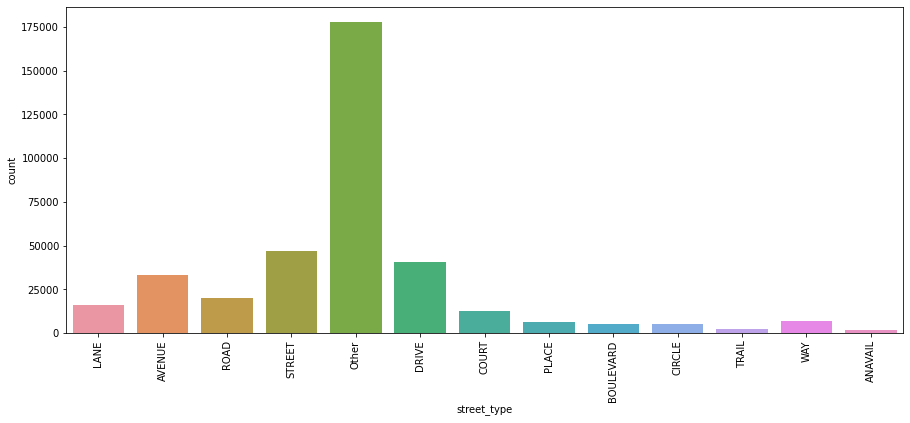

In [47]:
show_info_hist(data['street_type'])

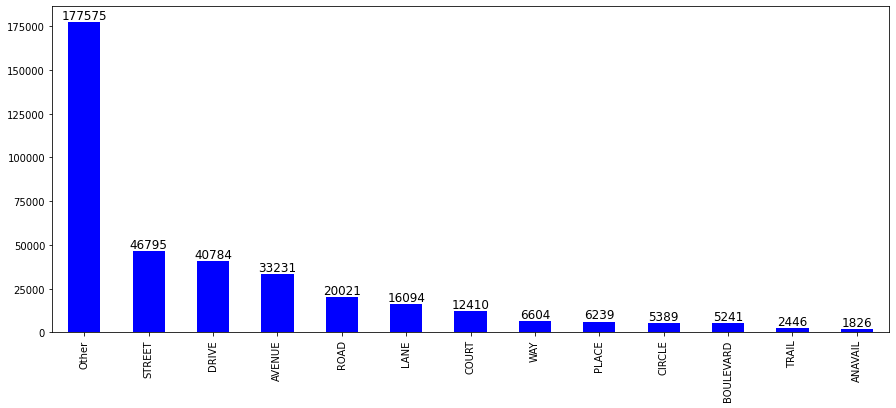

In [48]:
show_plot(data['street_type'])

In [49]:
data_dict['street'] = ' УДАЛИТЬ' 
data_dict['street_t'] = 'Техническая колонка, УДАЛИТЬ ' 
data_dict['street_type'] = 'Загнать в КАТЕГОРИИ ' 

# baths 

In [50]:
show_info(data['baths'])

Сколько пропусков? 105347

Процент пропусков? 28.118402263415675%

Описание:
count      269308
unique        226
top       2 Baths
freq        52072
Name: baths, dtype: object

Как распределено?
NaN                    105347
2 Baths                 52072
3 Baths                 35393
2                       20429
2.0                     16354
                        ...  
5.2 Baths                   1
35                          1
1 / 1-0 / 1-0 / 1-0         1
2.25 ba                     1
10.5 Baths                  1
Name: baths, Length: 227, dtype: int64

Какие значения?
['3.5' '3 Baths' '2 Baths' '8 Baths' nan '2' '3' 'Bathrooms: 2' '1,750'
 '4 Baths' '2 ba' 'Bathrooms: 5' '1,000' '7 Baths' '2.0' '3.0'
 'Bathrooms: 1' '4.0' '2.1 Baths' '2.5 Baths' '1' 'Bathrooms: 3' '4.5'
 '6 Baths' 'Bathrooms: 4' '3 ba' '5' '2,500' '5.5 Baths' '1.0' '5 Baths'
 '1.5' '4' '~' '2.5' '4,000' '3.5 Baths' '2,000' '3,000' '8.0' '1 ba' '0'
 '5.0' '1,500' '7.0' '1,250' '9 Baths' '2,250' '6.0' '12 Baths' '5

In [51]:
#Почистим колонку и постараемся извлечь количество ванных комнат

In [52]:
data['baths'] = data['baths'].apply(lambda x: str(x).lower())
data['baths'] = data['baths'].apply(lambda x: str(x).replace('baths','').replace('bathrooms','').replace('ba',''))

In [53]:
show_info(data['baths'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique       205
top          nan
freq      105347
Name: baths, dtype: object

Как распределено?
nan          105347
2             54756
3             37279
2             20429
2.0           16354
              ...  
3-1 / 2-2         1
: semimod         1
20.0              1
0.5               1
29                1
Name: baths, Length: 205, dtype: int64

Какие значения?
['3.5' '3 ' '2 ' '8 ' 'nan' '2' '3' ': 2' '1,750' '4 ' ': 5' '1,000' '7 '
 '2.0' '3.0' ': 1' '4.0' '2.1 ' '2.5 ' '1' ': 3' '4.5' '6 ' ': 4' '5'
 '2,500' '5.5 ' '1.0' '5 ' '1.5' '4' '~' '2.5' '4,000' '3.5 ' '2,000'
 '3,000' '8.0' '1 ' '0' '5.0' '1,500' '7.0' '1,250' '9 ' '2,250' '6.0'
 '12 ' '5.5' '3,500' '1.5 ' '2,750' ': 6' '4.5 ' '750' '5.5+' '6' '10 '
 ': 19' '10.0' '2.5+' '8' '7.5+' ': 10' '0 / 0' 'sq. ft. ' '4.5+' '18 '
 '-- ' ': 7' '7' '18' '3.5+' '1.5+' '11 ' '5,000' '1.75 ' '9' '12.0' '6.5'
 ': 8' '10' '19 ' ': 9' '16 ' '13 ' ': 13' '14' '

In [54]:
data['baths'] = data['baths'].apply(lambda x: x.replace(',','.'))

In [55]:
data['baths'] = data['baths'].apply(lambda x: str(x).replace(
    '+', '').replace('~', '2').replace('-- ', '2').replace(': ', '').replace(' ', ''))

In [56]:
data['baths'] = data['baths'].apply(lambda x: str(x).replace('semimod','2').replace('sq.ft','2').replace('—','2'))

In [57]:
data['baths'] = data['baths'].apply(lambda x: str(x).replace(
    '2-1/2-1/1-1/1-1','4').replace('1/1-0/1-0/1-0','4').replace('0/0','0').replace(
    '1-0/1-0/1','3').replace('3-1/2-2','3').replace('116/116/116','116').replace('1/1/1/1','4').replace('1-2','2'))

In [58]:
show_info(data['baths'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique       123
top          nan
freq      105347
Name: baths, dtype: object

Как распределено?
nan     105347
2        85879
3        53943
4        21394
2.0      16354
         ...  
35           1
39           1
20.0         1
0.5          1
4.75         1
Name: baths, Length: 123, dtype: int64

Какие значения?
['3.5' '3' '2' '8' 'nan' '1.750' '4' '5' '1.000' '7' '2.0' '3.0' '1' '4.0'
 '2.1' '2.5' '4.5' '6' '2.500' '5.5' '1.0' '1.5' '4.000' '2.000' '3.000'
 '8.0' '0' '5.0' '1.500' '7.0' '1.250' '9' '2.250' '6.0' '12' '3.500'
 '2.750' '750' '10' '19' '10.0' '7.5' '2.' '18' '11' '5.000' '1.75' '12.0'
 '6.5' '16' '13' '14' '9.0' '8.5' '1.1' '17' '241' '16.0' '10.5' '7.500'
 '11.0' '20' '40' '14.0' '2.75' '24' '22.0' '0.00' '2.25' '3.1' '3.25'
 '22' '32' '18.0' '0.0' '27' '26' '9.5' '15' '35' '3.75' '29' '116' '21'
 '5.2' '14.5' '76' '13.0' '15.0' '23' '43' '1.25' '34' '2.2' '55.0' '25'
 '12.5' '44' '0.5' '4.25'

In [59]:
data['baths'] = data['baths'].fillna('2')
data['baths'] = data['baths'].astype('float')

In [60]:
data['baths'].describe()

count    269308.000000
mean          3.376017
std          22.211476
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

In [61]:
bath25 = int(data.baths.quantile(0.25))
bath50 = int(data.baths.quantile(0.50))
bath75 = int(data.baths.quantile(0.75))

print('25 квантиль:',bath25)
print('50 квантиль:', bath50)
print('75 квантиль:', bath75)

25 квантиль: 2
50 квантиль: 2
75 квантиль: 3


In [62]:
#Напишем функцию, которая возвращает строковое значение, в дальнейшем трансформируем в категории 

def bath_col_cat(x):
    if x < bath25:
        return '<2'
    elif bath25 <= x <= bath75: 
        return '2'
    else:
        return '>2'

data['num_bath'] = data['baths'].apply(lambda x: bath_col_cat(x))


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique         3
top            2
freq      186901
Name: num_bath, dtype: object

Как распределено?
2     186901
>2    158934
<2     28820
Name: num_bath, dtype: int64

Какие значения?
['>2' '2' '<2']

Сколько уникальных?
3



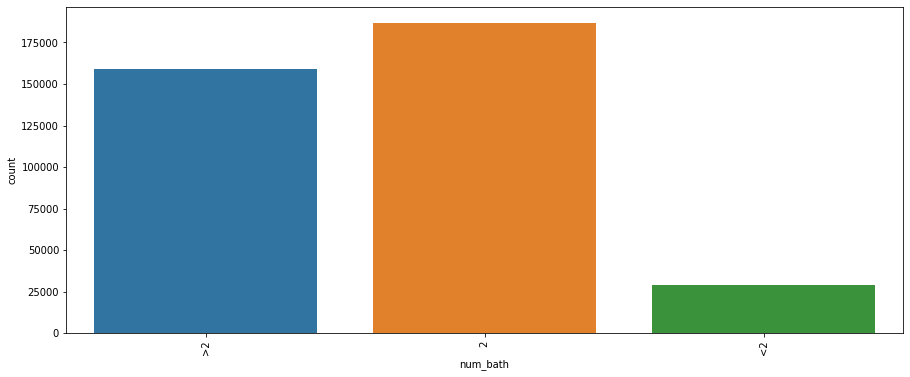

In [63]:
show_info_hist(data['num_bath'])

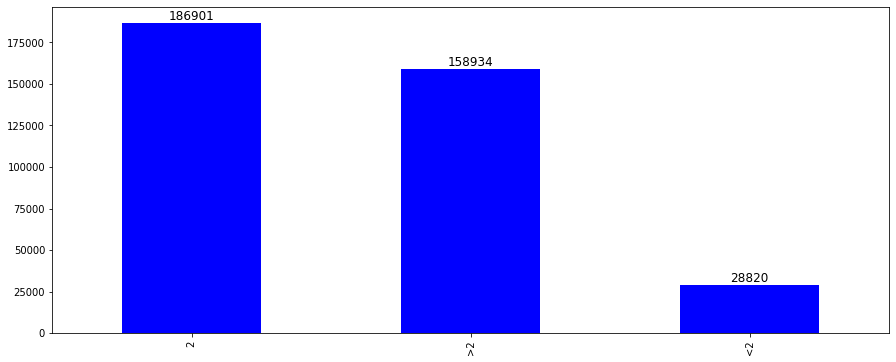

In [64]:
show_plot(data['num_bath'])

In [65]:
data_dict['baths'] = 'УДАЛИТЬ'
data_dict['num_bath'] = 'Перевести в КАТЕГОРИИ'

# homeFacts 

In [66]:
show_info(data['homeFacts'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count                                                374655
unique                                               318850
top       {'atAGlanceFacts': [{'factValue': '', 'factLab...
freq                                                   7142
Name: homeFacts, dtype: object

Как распределено?
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                           7142
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'

In [67]:
#from ast import literal_eval

homefact_dict = literal_eval(data['homeFacts'][1])
homefact_dict

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': '', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': '5828 sqft', 'factLabel': 'lotsize'},
  {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}

In [68]:
def foo(x):
    homefact_dict = literal_eval(x)
    lst = homefact_dict['atAGlanceFacts'][0].get('factValue')
    if lst:
        return str(lst)
    else:
        return np.nan
    
year = list(data[:].homeFacts.apply(foo))
year[:10]
data['year_built'] = year    
    

In [69]:
show_info(data['year_built'])

Сколько пропусков? 62054

Процент пропусков? 16.56297126689888%

Описание:
count     312601
unique       227
top         2019
freq       32139
Name: year_built, dtype: object

Как распределено?
NaN     62054
2019    32139
2006     7954
2005     7449
2007     7095
        ...  
1807        1
1808        1
1811        1
1804        1
1809        1
Name: year_built, Length: 228, dtype: int64

Какие значения?
['2019' '1961' '2006' nan '1920' '1976' '1970' '1965' '2015' '1996' '1982'
 '1905' '2008' '1899' '2016' '1954' '1989' '2014' '1915' '1994' '1910'
 '1923' '1960' '1977' '1972' '1963' '1981' '1949' '1930' '1991' '1958'
 '2005' '2017' '2018' '1983' '1928' '1998' '1997' '1964' '1974' '1940'
 '1973' '1968' '1999' '1918' '2007' '1984' '1946' '2003' '2000' '2004'
 '1969' '2002' '1952' '1947' '1957' '1978' '1956' '1967' '1975' '1988'
 '1955' '1950' '1959' '2012' '1924' '1966' '1992' '2001' '1995' '2010'
 '1971' '1909' '1953' '1993' '1990' '1980' '1985' '1951' '1907' '1885'
 '1941' '1927' '192

In [70]:
data['year_built'].describe().top

'2019'

In [71]:
def year(year):
    if year == '559990649990': return data['year_built'].describe().top
    elif year == 'No Data': return data['year_built'].describe().top
    else: return year
data['year_built'] = data['year_built'].apply(year).astype(float)        

In [72]:
show_info(data['year_built'])

Сколько пропусков? 62054

Процент пропусков? 16.56297126689888%

Описание:
count    312601.000000
mean       1979.471061
std          34.145187
min           1.000000
25%        1957.000000
50%        1985.000000
75%        2007.000000
max        2025.000000
Name: year_built, dtype: float64

Как распределено?
NaN       62054
2019.0    33322
2006.0     7954
2005.0     7449
2007.0     7095
          ...  
1740.0        1
1019.0        1
1788.0        1
1057.0        1
1808.0        1
Name: year_built, Length: 226, dtype: int64

Какие значения?
[2.019e+03 1.961e+03 2.006e+03       nan 1.920e+03 1.976e+03 1.970e+03
 1.965e+03 2.015e+03 1.996e+03 1.982e+03 1.905e+03 2.008e+03 1.899e+03
 2.016e+03 1.954e+03 1.989e+03 2.014e+03 1.915e+03 1.994e+03 1.910e+03
 1.923e+03 1.960e+03 1.977e+03 1.972e+03 1.963e+03 1.981e+03 1.949e+03
 1.930e+03 1.991e+03 1.958e+03 2.005e+03 2.017e+03 2.018e+03 1.983e+03
 1.928e+03 1.998e+03 1.997e+03 1.964e+03 1.974e+03 1.940e+03 1.973e+03
 1.968e+03 1.999e+03 1.918

In [73]:
year25 = int(data.year_built.quantile(0.25))
year50 = int(data.year_built.quantile(0.50))
year75 = int(data.year_built.quantile(0.75))

print('25 квантиль:',year25)
print('50 квантиль:', year50)
print('75 квантиль:', year75)

25 квантиль: 1957
50 квантиль: 1985
75 квантиль: 2007


In [74]:
def old_house(x):
    if x < year25: return 'very_old_house'
    elif year25 <= x <= year50: return 'old_house'
    elif year50 < x <= year75: return 'modern_house'
    elif x > year75: return 'new_house'
    else: return 'No info'
    
data['house_status'] = data['year_built'].apply(old_house)

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count           374655
unique               5
top       modern_house
freq             81161
Name: house_status, dtype: object

Как распределено?
modern_house      81161
old_house         79375
very_old_house    77662
new_house         74403
No info           62054
Name: house_status, dtype: int64

Какие значения?
['new_house' 'old_house' 'modern_house' 'No info' 'very_old_house']

Сколько уникальных?
5



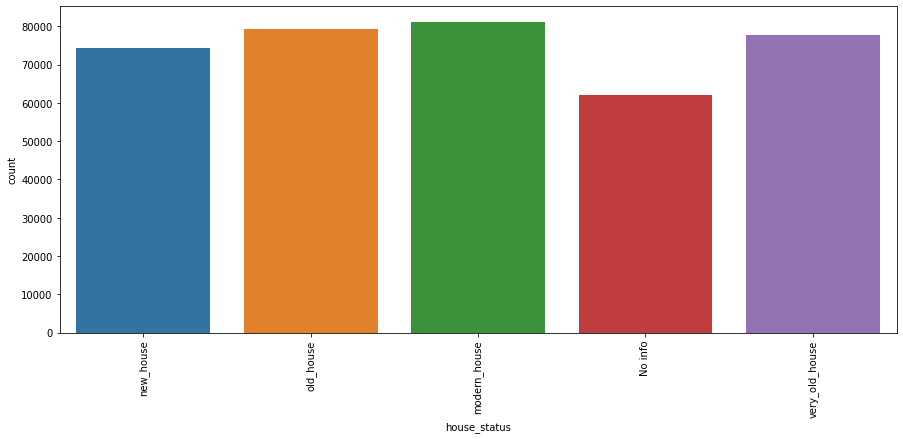

In [75]:
show_info_hist(data['house_status'])

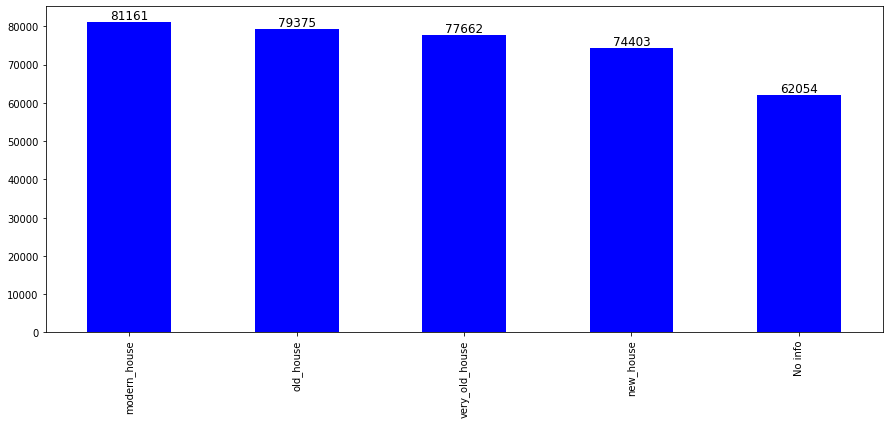

In [76]:
show_plot(data['house_status'])

In [77]:
data_dict['homeFacts'] = 'Не придумал, что делать, УДАЛИТЬ'

# fireplace 

In [78]:
show_info(data['fireplace'])

Сколько пропусков? 272136

Процент пропусков? 72.63642551147055%

Описание:
count     102519
unique      1653
top          yes
freq       50015
Name: fireplace, dtype: object

Как распределено?
NaN                                                                    272136
yes                                                                     50015
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
                                                                        ...  
Fireplace Insert, Living Room                                               1
Fireplace, HOA, Insulated Windows, Pool In-Ground, Secure Community         1
Ceiling Fan, Elevator                                                       1
Gas Logs, In Bedroom, In Great Room, Outside, Wood Burning                  1
Fire Pit,Free Standing,Ele

In [79]:
data['fireplace'] = data['fireplace'].apply(lambda x: str(x).replace('+',''))

In [80]:
data['fireplace'].value_counts().sample(50)

Dehumidifier, Fire Sprinkler System, Storage, Walk-In Closets, Water Filter          1
# Fireplaces - Gas                                                                  60
Gas Logs, In Bedroom, In Great Room, Wood Burning                                    2
FAMILYRM, Propane                                                                    5
Family Room Fireplace, Fireplace Insert                                              1
Flooring - Carpet, Fireplace - Wood Burning                                          4
Gas Piped, Living Room                                                               2
Family Room, Master Bedroom, Other Room                                              1
Gas, Family Room, Master Bedroom, Wood Burning                                       1
Gas Logs, In Kitchen/Dining Room                                                     3
Gas, Living Room, Master Bedroom, Wood Burning                                       5
Extra Closets, Redecorated, Storage, Walk-I

In [81]:
data['fireplace'] = data['fireplace'].apply(lambda x: str(x).lower())

In [82]:
data['fireplace_mentions'] = data['fireplace'].apply(lambda x: len(str(x).split(',')))
data['fireplace_mentions'].value_counts()

1     369063
2       3285
3       1174
4        608
5        327
6        175
7         10
8          4
9          3
10         2
11         1
12         1
14         1
15         1
Name: fireplace_mentions, dtype: int64

In [83]:
show_info(data['fireplace_mentions'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    374655.000000
mean          1.026205
std           0.254669
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          15.000000
Name: fireplace_mentions, dtype: float64

Как распределено?
1     369063
2       3285
3       1174
4        608
5        327
6        175
7         10
8          4
9          3
10         2
11         1
12         1
14         1
15         1
Name: fireplace_mentions, dtype: int64

Какие значения?
[ 1  2  3  4  6  5  7  8 10 15 12 11  9 14]

Сколько уникальных?
14


In [84]:
nums = ['1','2','3','4','5','6','one','two','three','four','five','six']

def fireplace(f_pl):
    if f_pl == 'yes': return 'available'
    elif f_pl in nums: return 'numeric_quantity'
    elif 'gas' in f_pl: return 'gas'
    elif 'fireplace' in f_pl: return 'fireplace'
    elif 'wood' in f_pl: return 'wood'
    elif 'ceiling' in f_pl: return 'ceiling'
    elif 'living' in f_pl: return 'room'
    elif 'dining' in f_pl: return 'room'
    elif 'kitchen' in f_pl:return 'room'
    elif 'room' in f_pl: return 'room'
    else: return 'other'
    
data['fireplace'] = data['fireplace'].apply(lambda x: fireplace(x))
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating,num_prop_descr,street_t,street_type,num_bath,year_built,house_status,fireplace_mentions
0,active,NaN,single family home,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",gas,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000",active,family,3,'ln',LANE,>2,2019.0,new_house,1
1,for sale,NaN,single-family home,12911 e heroy ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",other,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000",for sale,family,3,'ave',AVENUE,2,2019.0,new_house,1
2,for sale,NaN,single-family home,2005 westridge rd,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",available,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000",for sale,family,3,'rd',ROAD,2,1961.0,old_house,1
3,for sale,NaN,single-family home,4311 livingston ave,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",available,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000",for sale,family,3,'ave',AVENUE,>2,2006.0,modern_house,1
4,for sale,NaN,lot/land,1524 kiscoe st,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",other,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000",for sale,Other,2,'st',STREET,>2,NaN,No info,1


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique         8
top        other
freq      276581
Name: fireplace, dtype: object

Как распределено?
other               276581
available            70634
numeric_quantity     17938
gas                   3208
fireplace             2422
wood                  1503
ceiling               1222
room                  1147
Name: fireplace, dtype: int64

Какие значения?
['gas' 'other' 'available' 'numeric_quantity' 'fireplace' 'room' 'wood'
 'ceiling']

Сколько уникальных?
8



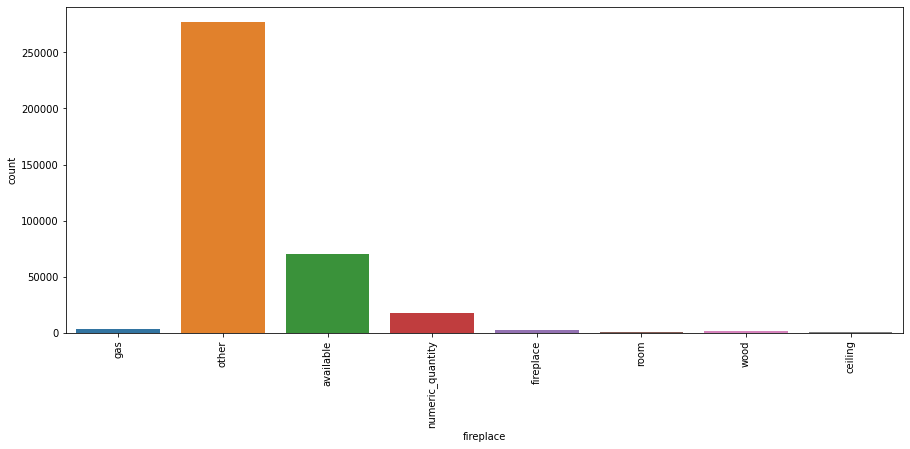

In [85]:
show_info_hist(data['fireplace'])

In [86]:
data['fireplace'] = data['fireplace'].apply(lambda x: x if x in ['other', 'available', 'numeric_quantity'] else 'something else')

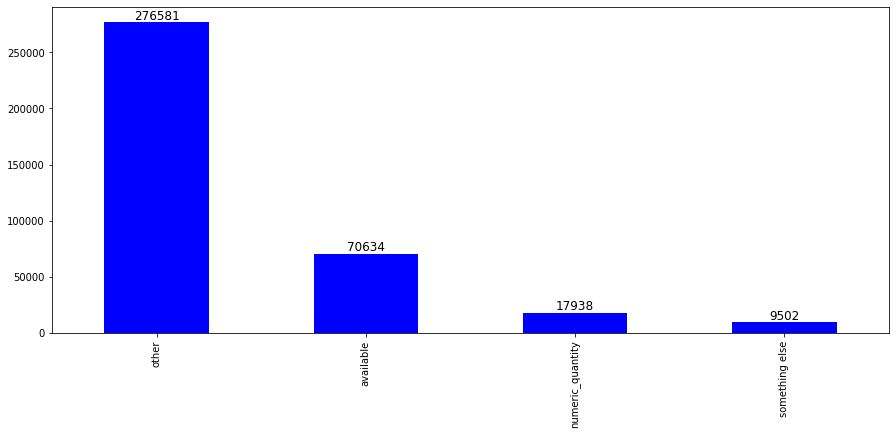

In [87]:
show_plot(data['fireplace'])

In [88]:
data_dict['fireplace'] = 'Перевести в КАТЕГОРИИ'

In [89]:
data_dict['fireplace_mentions'] = 'Получилось крайне неравномерное распределение, придется УДАЛИТЬ'

# city 

In [90]:
show_info(data['city'])

Сколько пропусков? 34

Процент пропусков? 0.009075015681093273%

Описание:
count      374621
unique       2019
top       Houston
freq        24406
Name: city, dtype: object

Как распределено?
Houston                      24406
San Antonio                  15501
Miami                        15411
Jacksonville                  9892
Dallas                        8770
                             ...  
Wooton                           1
Outside Area (Outside Ca)        1
Corryton                         1
Indian Creek Village             1
Idyllwild                        1
Name: city, Length: 2020, dtype: int64

Какие значения?
['Southern Pines' 'Spokane Valley' 'Los Angeles' ... 'Bedford Hts'
 'HAINES CITY' 'Blue Springs']

Сколько уникальных?
2020


In [91]:
data['city'].value_counts().head(34)

Houston             24406
San Antonio         15501
Miami               15411
Jacksonville         9892
Dallas               8770
Brooklyn             7244
New York             6903
Chicago              6893
Charlotte            6525
Las Vegas            5975
Fort Worth           5478
Orlando              5170
Austin               5133
Fort Lauderdale      5082
Cleveland            5006
Nashville            4987
Philadelphia         4768
Tampa                4706
Washington           4584
Los Angeles          4164
Seattle              4056
Atlanta              3950
Ocala                3322
Palm Coast           3245
Kissimmee            3114
Detroit              3113
Indianapolis         2679
Miami Beach          2622
Lehigh Acres         2492
Saint Petersburg     2491
Memphis              2484
Raleigh              2451
Denver               2249
Portland             2121
Name: city, dtype: int64

#### Много городов с маленьким кол-вом объявлений, сделаем перегруппировку на условные "Крупный город" - "Маленький город" 

In [92]:
%%time

pop_city=list(data['city'].value_counts()[:5].keys())
less_pop_city=list(data['city'].value_counts()[5:30].keys())

def city_size(c_name):
    if c_name in pop_city:
        return 'pop_city'
    elif c_name in less_pop_city:
        return 'less_pop_city'
    else:
        return 'min_pop_city'
    
    
data['city_rating'] = data['city'].apply(lambda x: city_size(x))
data.head()

CPU times: user 397 ms, sys: 0 ns, total: 397 ms
Wall time: 397 ms


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating,num_prop_descr,street_t,street_type,num_bath,year_built,house_status,fireplace_mentions,city_rating
0,active,NaN,single family home,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",something else,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000",active,family,3,'ln',LANE,>2,2019.0,new_house,1,min_pop_city
1,for sale,NaN,single-family home,12911 e heroy ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",other,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000",for sale,family,3,'ave',AVENUE,2,2019.0,new_house,1,min_pop_city
2,for sale,NaN,single-family home,2005 westridge rd,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",available,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000",for sale,family,3,'rd',ROAD,2,1961.0,old_house,1,less_pop_city
3,for sale,NaN,single-family home,4311 livingston ave,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",available,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000",for sale,family,3,'ave',AVENUE,>2,2006.0,modern_house,1,pop_city
4,for sale,NaN,lot/land,1524 kiscoe st,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",other,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000",for sale,Other,2,'st',STREET,>2,NaN,No info,1,min_pop_city


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count           374655
unique               3
top       min_pop_city
freq            186973
Name: city_rating, dtype: object

Как распределено?
min_pop_city     186973
less_pop_city    113702
pop_city          73980
Name: city_rating, dtype: int64

Какие значения?
['min_pop_city' 'less_pop_city' 'pop_city']

Сколько уникальных?
3



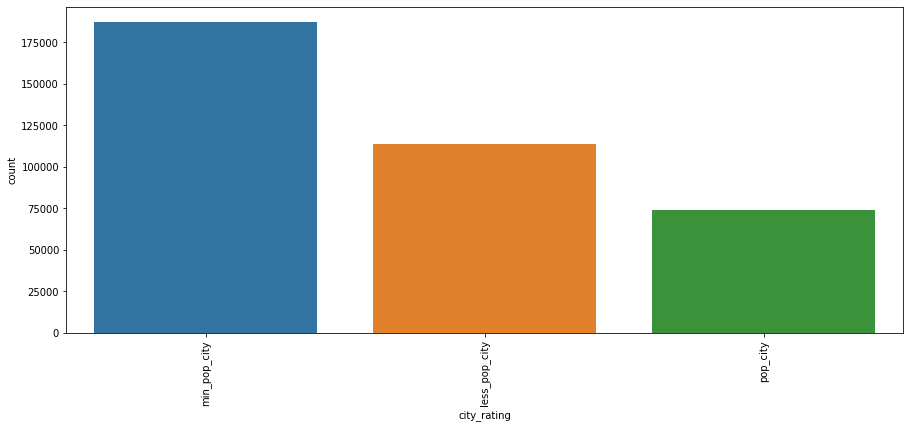

In [93]:
show_info_hist(data['city_rating'])

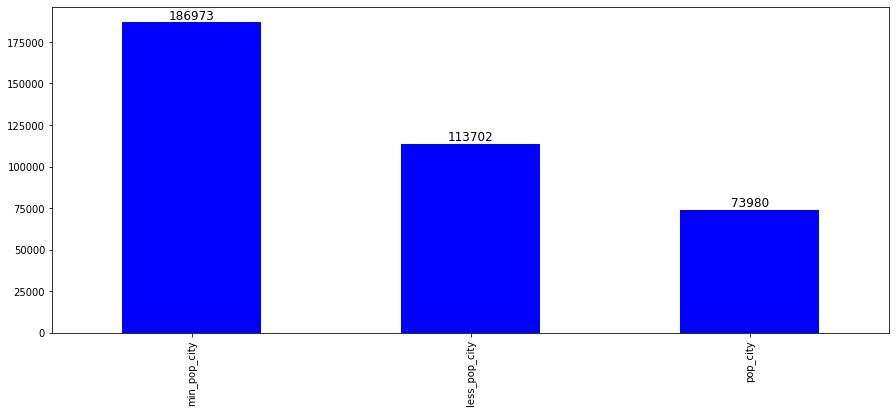

In [94]:
show_plot(data['city_rating'])

In [95]:
data_dict['city'] = 'Необходимо УДАЛИТЬ'
data_dict['city_rating'] = 'Перевести три значения в КАТЕГОРИИ'

# schools 

In [96]:
show_info(data['schools'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count                                                374655
unique                                               295362
top       [{'rating': [], 'data': {'Distance': [], 'Grad...
freq                                                   4177
Name: schools, dtype: object

Как распределено?
[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [97]:
school_dict = literal_eval(data['schools'][0])
school_dict

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

In [98]:
school_dict[0]['data'].get('Distance')

['2.7 mi',
 '3.6 mi',
 '5.1 mi',
 '4.0 mi',
 '10.5 mi',
 '12.6 mi',
 '2.7 mi',
 '3.1 mi']

In [99]:
def foo(x):
    school_dict = literal_eval(x)
    sch = school_dict[0]['data'].get('Distance')
    if sch:
        return sch
    else:
        return '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111'
    
sch_dict = list(data[:].schools.apply(foo))
sch_dict[:10]

[['2.7 mi',
  '3.6 mi',
  '5.1 mi',
  '4.0 mi',
  '10.5 mi',
  '12.6 mi',
  '2.7 mi',
  '3.1 mi'],
 ['1.65mi', '1.32mi', '1.01mi'],
 ['1.19mi', '2.06mi', '2.63mi'],
 ['1.05mi', '0.1mi', '1.05mi', '0.81mi'],
 ['5.96mi', '3.25mi', '3.03mi'],
 '1111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111',
 ['0.8 mi', '8.3 mi', '4.2 mi', '2.0 mi'],
 ['0.7 mi', '0.4 mi', '2.2 mi'],
 ['5.6 mi', '5.6 mi', '6.8 mi', '6.5 mi', '6.8 mi', '6.8 mi'],
 ['0.7 mi', '0.6 mi', '1.9 mi']]

In [100]:
data['distance'] = sch_dict
#data['dv'] = ''

In [101]:
len(data['distance'])

374655

In [102]:
mean_distance=[]

In [103]:
'''Наша цель - извлечь дистанции до школ и посчитать среднее значение'''
for x in range(len(data['distance'])):
    try:
        l = data['distance'][x]
        l1=[]
        for x in l:
            x =str(x).replace('mi','').replace('[','').replace(']','')
            l1.append(x)
        test_list = list(map(float, l1))
        mean_distance.append(sum(test_list)/len(test_list))
    except:
        mean_distance.append('no info')
        continue

In [104]:
len(mean_distance)

374655

In [105]:
data['distance_value'] = mean_distance
data['distance_value'] = data['distance_value'].apply(lambda x: str(x).replace('no info', '1.0')).astype(float)
data['distance_value'] = data['distance_value'].apply(lambda x: round(x,2))
show_info(data['distance_value'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    374655.000000
mean          2.828644
std           5.865467
min           0.000000
25%           1.030000
50%           1.750000
75%           3.230000
max        1590.830000
Name: distance_value, dtype: float64

Как распределено?
1.00       9881
0.90       3215
1.10       3120
1.20       3005
1.40       2849
           ... 
22.23         1
24.62         1
1590.83       1
22.61         1
0.00          1
Name: distance_value, Length: 2003, dtype: int64

Какие значения?
[ 5.54  1.33  1.96 ... 16.54 29.27 18.  ]

Сколько уникальных?
2003


<AxesSubplot:ylabel='Frequency'>

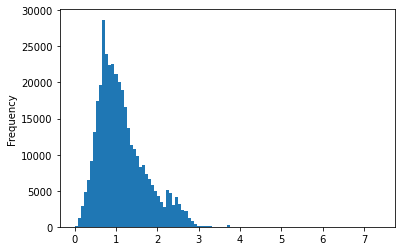

In [106]:
np.log(data['distance_value']+1).plot(kind='hist', bins=100)

In [107]:
dist25 = int(data.distance_value.quantile(0.25))
dist50 = int(data.distance_value.quantile(0.50))
dist75 = int(data.distance_value.quantile(0.75))

print('25 квантиль:', dist25)
print('50 квантиль:', dist50)
print('75 квантиль:', dist75)

25 квантиль: 1
50 квантиль: 1
75 квантиль: 3


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count        374655
unique            4
top       need_time
freq         180984
Name: school_dist, dtype: object

Как распределено?
need_time    180984
too far      102119
close         81671
ok             9881
Name: school_dist, dtype: int64

Какие значения?
['too far' 'need_time' 'close' 'ok']

Сколько уникальных?
4



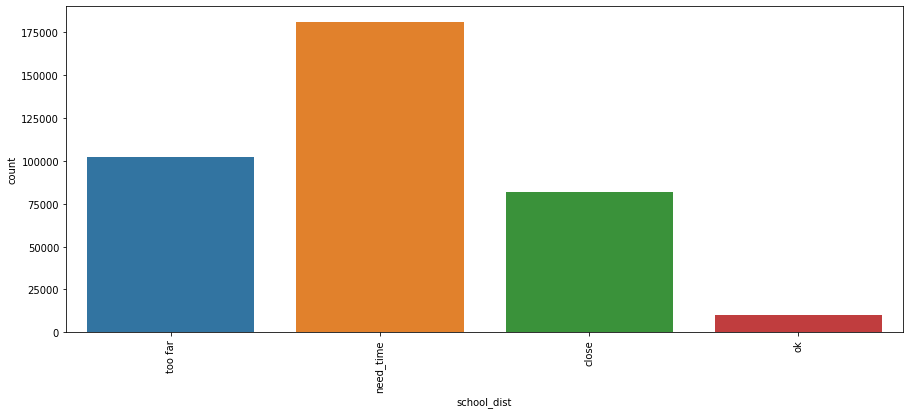

In [108]:
'''создадим признако "удаленность от школ" '''
def far_away(x):
    if x < dist25:
        return 'close'
    elif dist25 <= x <= dist50:
        return 'ok'
    elif dist50 <= x <= dist75:
        return 'need_time'
    else: 
        return 'too far'
    
data['school_dist'] = data['distance_value'].apply(far_away)
show_info_hist(data['school_dist'])

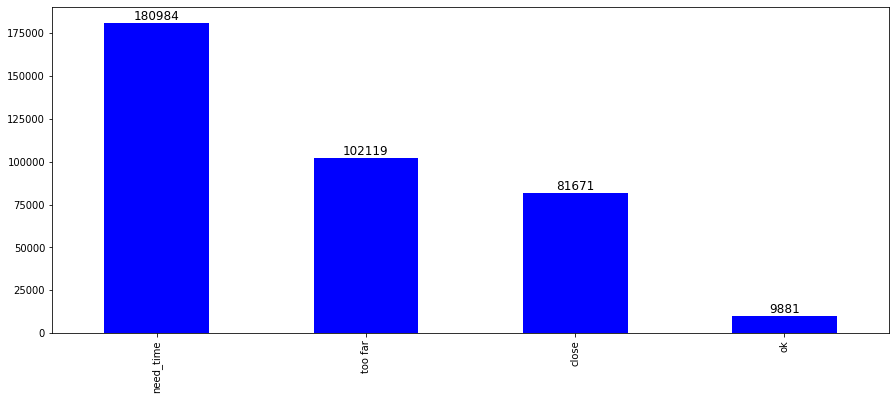

In [109]:
show_plot(data['school_dist'])

In [110]:
'''Цель - создать признак "сколько школ вокруг" '''
check_list = []
for x in sch_dict[:]:
    check_list.append(len(x))

data['num_schools_around'] = check_list

def check(num):
    if num == 100:
        return 'no info'
    else:
        return num
    
data['num_schools_around'] = data['num_schools_around'].apply(check)    

In [111]:
show_info(data['num_schools_around'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique        27
top            3
freq      205747
Name: num_schools_around, dtype: int64

Как распределено?
3          205747
8           40219
2           35085
5           29035
4           22897
6           11635
1            8530
7            6690
no info      4257
24           2063
22           1784
13           1061
12            869
10            771
63            764
11            751
9             539
15            518
14            437
65            355
49            280
61            128
16            120
21             96
17             11
26             10
19              3
Name: num_schools_around, dtype: int64

Какие значения?
[8 3 4 'no info' 6 5 2 1 10 7 24 15 22 11 12 13 65 14 63 9 16 49 21 61 19
 26 17]

Сколько уникальных?
27


In [112]:
nums_schools = list(data['num_schools_around'].value_counts()[0:9].keys())
nums_schools

[3, 8, 2, 5, 4, 6, 1, 7, 'no info']

In [113]:
def num_schools(num):
    if num in nums_schools:
        return num
    else: return 'Other'

data['num_schools_around'] = data['num_schools_around'].apply(num_schools)


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique        10
top            3
freq      205747
Name: num_schools_around, dtype: int64

Как распределено?
3          205747
8           40219
2           35085
5           29035
4           22897
6           11635
Other       10560
1            8530
7            6690
no info      4257
Name: num_schools_around, dtype: int64

Какие значения?
[8 3 4 'no info' 6 5 2 1 'Other' 7]

Сколько уникальных?
10



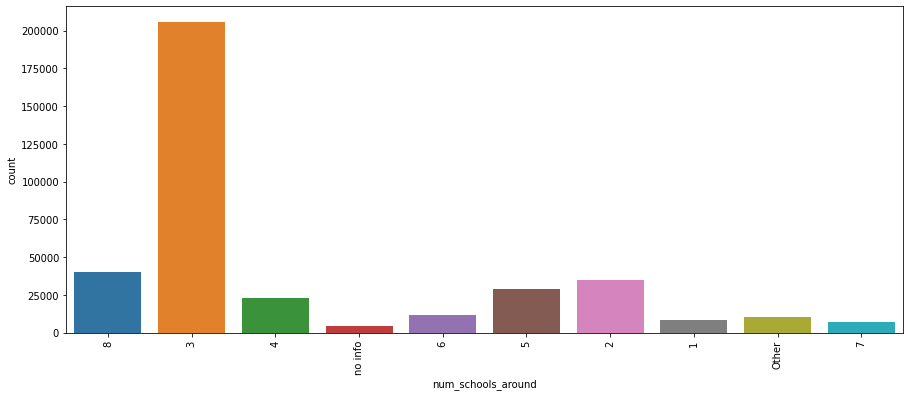

In [114]:
show_info_hist(data['num_schools_around'])

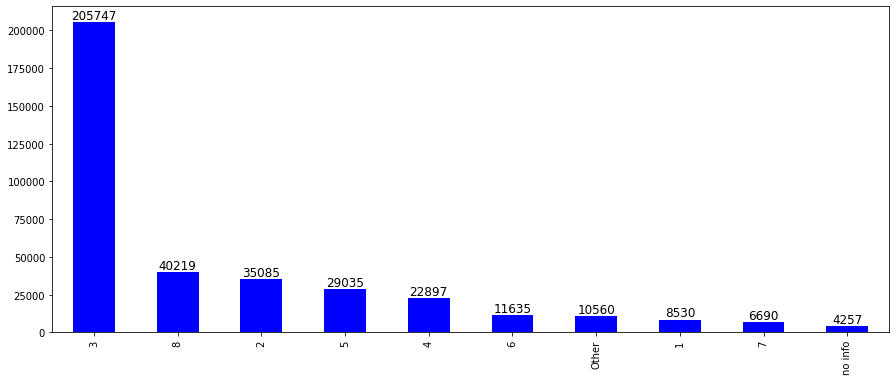

In [115]:
show_plot(data['num_schools_around'])

In [116]:
data_dict['schools'] = 'По хорошему можно играться, но пока УДАЛИМ, чтобы оценить результаты'

In [117]:
data['distance_value'] = data['distance_value'].apply(lambda x: np.log(x+1))


# sqft 

In [118]:
show_info(data['sqft'])

Сколько пропусков? 40095

Процент пропусков? 10.701845698042199%

Описание:
count     334560
unique     25373
top            0
freq       11853
Name: sqft, dtype: object

Как распределено?
NaN           40095
0             11853
1,200 sqft      829
1,000 sqft      648
1,100 sqft      570
              ...  
5,936 sqft        1
10,210            1
8,087 sqft        1
4468              1
6491              1
Name: sqft, Length: 25374, dtype: int64

Какие значения?
['2900' '1,947 sqft' '3,000 sqft' ... '4371' '13,870 sqft'
 'Total interior livable area: 4,615 sqft']

Сколько уникальных?
25374


Много NaN и нулей - но площать не может быть нулевой. Пришлось взять на себя смелость заполнить константой, хотя можно было бы сделать разбиение по другим категориальным признакам и заполнить соответствующим образом, но с лету не получилось

In [119]:
#data['sqft'] = data['sqft'].apply(lambda x: str(x).replace(',','.')) 
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('Total interior livable area: ',''))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace(' sqft ',''))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('sqft',''))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace(' ',''))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('--', 'nan'))
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('-',  ','))

In [120]:
data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('nan', '1000'))

def repl_zero(x):
    if x == '0':
        return '1000'
    else:
        return x
    
data['sqft'] = data['sqft'].apply(repl_zero)    
#data['sqft'] = data['sqft'].apply(lambda x: str(x).replace('0','1000'))

In [121]:
# import locale
# locale.setlocale(locale.LC_ALL,'en_US.UTF-8')
#data['sqft'] = data['sqft'].apply(lambda x: locale.atoi(x))

In [122]:
def make_sqft(x):
    x = re.sub('[^0-9]', '', x)
    x = int(x)
    return x

data['sqft'] = data['sqft'].apply(make_sqft)
data['sqft'].describe()

count    3.746550e+05
mean     6.062864e+03
std      1.499402e+06
min      1.000000e+00
25%      1.035000e+03
50%      1.656000e+03
75%      2.458000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [123]:
show_info(data['sqft'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    3.746550e+05
mean     6.062864e+03
std      1.499402e+06
min      1.000000e+00
25%      1.035000e+03
50%      1.656000e+03
75%      2.458000e+03
max      7.959794e+08
Name: sqft, dtype: float64

Как распределено?
1000      53777
1200       1411
1500       1010
1800        983
1100        935
          ...  
124146        1
7796          1
9843          1
9930          1
271380        1
Name: sqft, Length: 9879, dtype: int64

Какие значения?
[ 2900  1947  3000 ...  5789  6193 13870]

Сколько уникальных?
9879


In [124]:
data['sqft'] = data['sqft'].astype('float')

<AxesSubplot:>

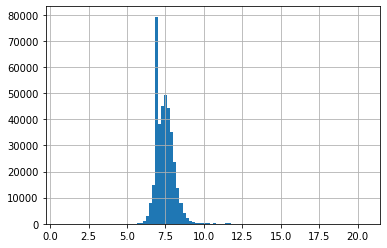

In [125]:
np.log(data['sqft']+1).hist(bins=100)

In [126]:
x

['0.3 mi', '1.1 mi', '4.1 mi']

In [127]:
data['sqft'] = data['sqft'].apply(lambda x: np.log(x+1))

In [128]:
show_info(data['sqft'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count    374655.000000
mean          7.459834
std           0.616200
min           0.693147
25%           6.943122
50%           7.412764
75%           7.807510
max          20.495084
Name: sqft, dtype: float64

Как распределено?
6.908755     53777
7.090910      1411
7.313887      1010
7.496097       983
7.003974       935
             ...  
9.062768         1
11.400216        1
8.556991         1
9.212538         1
10.003107        1
Name: sqft, Length: 9879, dtype: int64

Какие значения?
[7.97281078 7.57455848 8.00670085 ... 8.66388757 8.73133636 9.53755561]

Сколько уникальных?
9879


In [129]:
data_dict['sqft'] = 'Числовая, надо логарифм накинуть'

## zipcode 

In [130]:
show_info(data['zipcode'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique      4541
top        32137
freq        2139
Name: zipcode, dtype: object

Как распределено?
32137         2139
33131         1561
34747         1488
78245         1383
34759         1333
              ... 
1103             1
27603-2352       1
27713-2517       1
63123            1
50525            1
Name: zipcode, Length: 4541, dtype: int64

Какие значения?
['28387' '99216' '90049' ... '20191' '64015' '44704']

Сколько уникальных?
4541


In [131]:
data_dict['zipcode'] = 'Не является уникальным для каждой строки, но что скрыто за этой колонкой - мне не ясно. \
Для перевода в категорию тоже не подходит. УДАЛИМ'

## beds 

In [132]:
show_info(data['beds'])

Сколько пропусков? 90929

Процент пропусков? 24.2700617901803%

Описание:
count     283726
unique      1147
top       3 Beds
freq       53072
Name: beds, dtype: object

Как распределено?
NaN           90929
3 Beds        53072
4 Beds        35219
3             31190
2 Beds        26189
              ...  
1.36 acres        1
5,876 sqft        1
44                1
4,660 sqft        1
5,127 sqft        1
Name: beds, Length: 1148, dtype: int64

Какие значения?
['4' '3 Beds' '5 Beds' ... '2.72 acres' '9,565 sqft' '8,479 sqft']

Сколько уникальных?
1148


#### Уже видно, что данные грязные, будем вычищать 

In [133]:
data['beds'].value_counts().head(20)

3 Beds    53072
4 Beds    35219
3         31190
2 Beds    26189
4         19915
2         15997
Baths     15258
3 bd      12678
5 Beds    11226
4 bd       8193
3.0        8085
5          6392
4.0        5231
2 bd       5166
1          4583
6 Beds     3791
5 bd       2619
2.0        2429
6          1792
5.0        1372
Name: beds, dtype: int64

In [134]:
data['beds'] = data['beds'].apply(lambda x: str(x)[:1])

In [135]:
data['beds'] = data['beds'].apply(lambda x: '1' if '1' in x else '2' if '2' in x else '3' if '3' in x 
                                  else '4' if '4' in x else '5' if '5' in x else '6 or more')

In [136]:
data['beds'].value_counts().head(20)

6 or more    121254
3            105190
4             68719
2             50089
5             21910
1              7493
Name: beds, dtype: int64

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count        374655
unique            6
top       6 or more
freq         121254
Name: beds, dtype: object

Как распределено?
6 or more    121254
3            105190
4             68719
2             50089
5             21910
1              7493
Name: beds, dtype: int64

Какие значения?
['4' '3' '5' '6 or more' '2' '1']

Сколько уникальных?
6



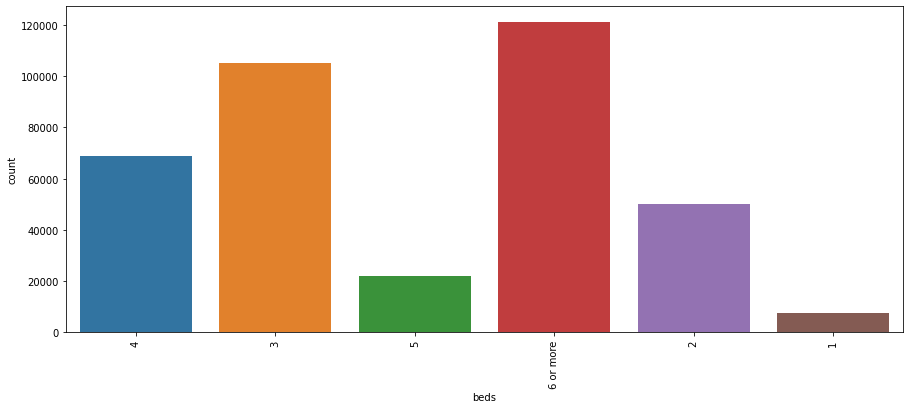

In [137]:
show_info_hist(data['beds'])

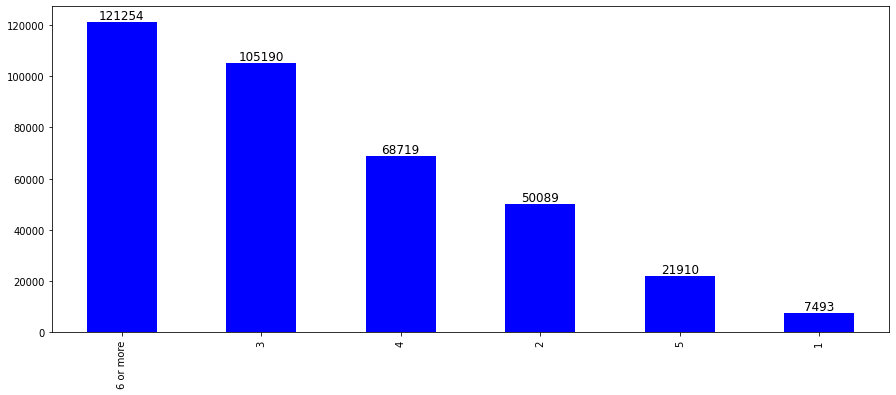

In [138]:
show_plot(data['beds'])

In [139]:
data_dict['beds'] = 'Сделал несколько категорий, загнать в категории'

## state 

In [140]:
show_info(data['state'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count     374655
unique        39
top           FL
freq      114652
Name: state, dtype: object

Как распределено?
FL    114652
TX     83352
NY     24335
CA     23207
NC     21778
TN     18230
WA     13733
OH     12431
IL      8851
NV      8421
GA      6637
CO      6377
PA      5510
MI      5126
DC      4584
AZ      3347
IN      3293
OR      2778
MA      1498
UT      1321
MD      1086
VT       864
MO       832
VA       800
WI       452
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
BA         1
AL         1
OS         1
Fl         1
OT         1
Name: state, dtype: int64

Какие значения?
['NC' 'WA' 'CA' 'TX' 'FL' 'PA' 'TN' 'IA' 'NY' 'OR' 'DC' 'NV' 'AZ' 'GA'
 'IL' 'NJ' 'MA' 'OH' 'IN' 'UT' 'MI' 'VT' 'MD' 'CO' 'VA' 'KY' 'MO' 'WI'
 'ME' 'MS' 'OK' 'SC' 'MT' 'DE' 'Fl' 'BA' 'AL' 'OT' 'OS']

Сколько уникальных?
39


In [141]:
%%time

extra_pop_states=list(data['state'].value_counts()[:2].keys())
pop_states=list(data['state'].value_counts()[2:7].keys())
other_states=list(data['state'].value_counts()[7:].keys())

def state_rating(st_name):
    if st_name in extra_pop_states:
        return 'extra_pop_state'
    elif st_name in pop_states:
        return 'pop_state'
    else:
        return 'other_state'
    
    
data['state_rating'] = data['state'].apply(lambda x: state_rating(x))
data.head()

CPU times: user 483 ms, sys: 2.99 ms, total: 486 ms
Wall time: 487 ms


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating,num_prop_descr,street_t,street_type,num_bath,year_built,house_status,fireplace_mentions,city_rating,distance,distance_value,school_dist,num_schools_around,state_rating
0,active,NaN,single family home,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",something else,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",7.972811,28387,4,NC,NaN,NaN,NaN,611019,"$418,000",active,family,3,'ln',LANE,>2,2019.0,new_house,1,min_pop_city,"[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...",1.877937,too far,8,pop_state
1,for sale,NaN,single-family home,12911 e heroy ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",other,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",7.574558,99216,3,WA,2.0,NaN,NaN,201916904,"$310,000",for sale,family,3,'ave',AVENUE,2,2019.0,new_house,1,min_pop_city,"[1.65mi, 1.32mi, 1.01mi]",0.845868,need_time,3,pop_state
2,for sale,NaN,single-family home,2005 westridge rd,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",available,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",8.006701,90049,3,CA,1.0,NaN,yes,FR19221027,"$2,895,000",for sale,family,3,'rd',ROAD,2,1961.0,old_house,1,less_pop_city,"[1.19mi, 2.06mi, 2.63mi]",1.085189,need_time,3,pop_state
3,for sale,NaN,single-family home,4311 livingston ave,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",available,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",8.773075,75205,5,TX,3.0,NaN,NaN,14191809,"$2,395,000",for sale,family,3,'ave',AVENUE,>2,2006.0,modern_house,1,pop_city,"[1.05mi, 0.1mi, 1.05mi, 0.81mi]",0.559616,close,4,extra_pop_state
4,for sale,NaN,lot/land,1524 kiscoe st,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",other,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6.908755,32908,6 or more,FL,NaN,NaN,NaN,861745,"$5,000",for sale,Other,2,'st',STREET,>2,NaN,No info,1,min_pop_city,"[5.96mi, 3.25mi, 3.03mi]",1.625311,too far,3,extra_pop_state


Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count              374655
unique                  3
top       extra_pop_state
freq               198004
Name: state_rating, dtype: object

Как распределено?
extra_pop_state    198004
pop_state          101283
other_state         75368
Name: state_rating, dtype: int64

Какие значения?
['pop_state' 'extra_pop_state' 'other_state']

Сколько уникальных?
3



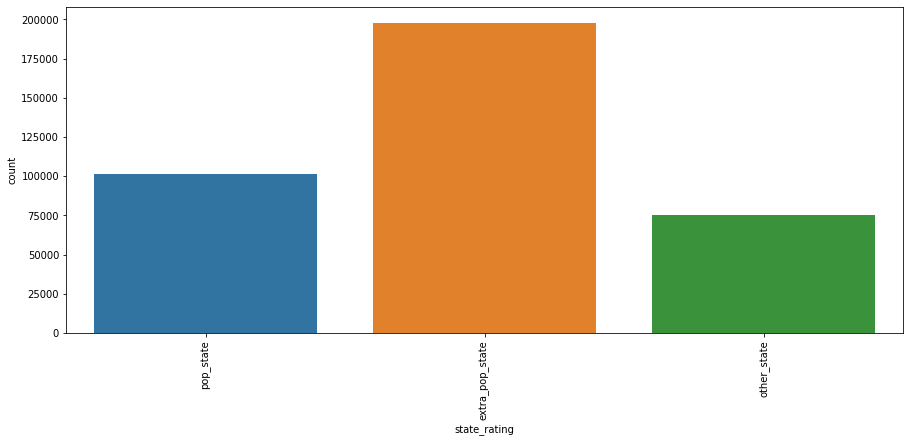

In [142]:
show_info_hist(data['state_rating'])

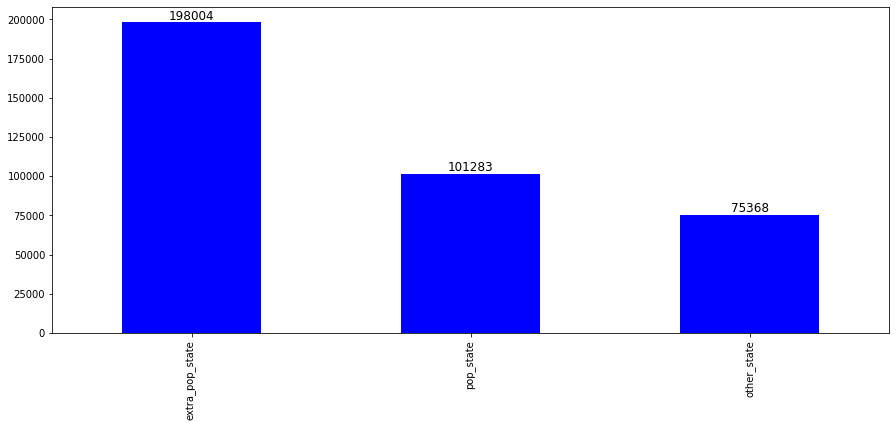

In [143]:
show_plot(data['state_rating'])

In [144]:
data_dict['state'] = 'УДАЛИТЬ за дальнейшей ненадобностью'

In [145]:
data_dict['state_rating'] = 'Разделил штаты на две группы. Загнать в КАТЕГОРИИ' 

## stories 

In [146]:
show_info(data['stories'])

Сколько пропусков? 149753

Процент пропусков? 39.97090656737532%

Описание:
count     224902
unique       348
top          1.0
freq       66805
Name: stories, dtype: object

Как распределено?
NaN                                           149753
1.0                                            66805
2.0                                            55003
1                                              22794
2                                              17976
                                               ...  
Log Home                                           1
2 Stories, Tear Down                               1
82                                                 1
Townhouse-2 Story, T3-Townhouse 3+ Stories         1
66                                                 1
Name: stories, Length: 349, dtype: int64

Какие значения?
[nan '2.0' '1.0' '3.0' 'One' '2' 'Multi/Split' '4.0' '0.0' '0' 'One Level'
 '1' '9.0' '3' '1 Level, Site Built' 'One Story' '3.00' '1.00' '14.0'
 'Two' '3+' '1 Story' 

In [147]:
data['stories'].value_counts(dropna=False).head(20)

NaN        149753
1.0         66805
2.0         55003
1           22794
2           17976
3.0         11230
0.0          7209
One          5758
0            4231
3            4201
9.0          2914
2.00         2775
Two          2495
4.0          2136
2 Story      1970
1 Story      1253
1.00         1200
4             888
3+            868
6.0           716
Name: stories, dtype: int64

In [148]:
data['stories'] = data['stories'].apply(lambda x: str(x).lower())
data['stories'] = data['stories'].apply(lambda x: 1 if '1' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 1 if 'one' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if '2' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 2 if 'two' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 3 if '3' in str(x) else x)
data['stories'] = data['stories'].apply(lambda x: 3 if 'three' in str(x) else x)


In [149]:
data['stories'].value_counts().head(10)

nan    149753
1      101705
2       82186
3       17936
0.0      7209
0        4231
9.0      2914
4.0      2136
4         888
6.0       716
Name: stories, dtype: int64

In [150]:
def story_change(story):
    if story == 1: return 'Two'
    elif story == 2: return 'One'
    elif story == 3: return 'Three'
    elif story == 'nan': return 'No info'
    else: return 'Other'
    
data['stories'] = data['stories'].apply(lambda x: story_change(x))    

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count      374655
unique          5
top       No info
freq       149753
Name: stories, dtype: object

Как распределено?
No info    149753
Two        101705
One         82186
Other       23075
Three       17936
Name: stories, dtype: int64

Какие значения?
['No info' 'One' 'Two' 'Three' 'Other']

Сколько уникальных?
5



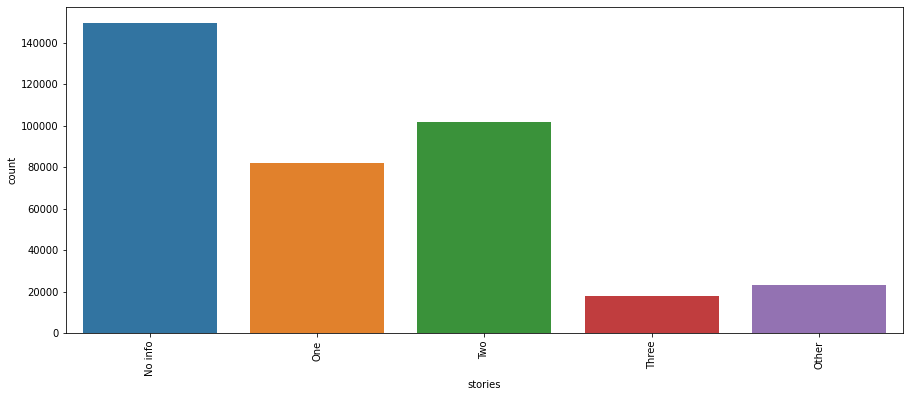

In [151]:
show_info_hist(data['stories'])

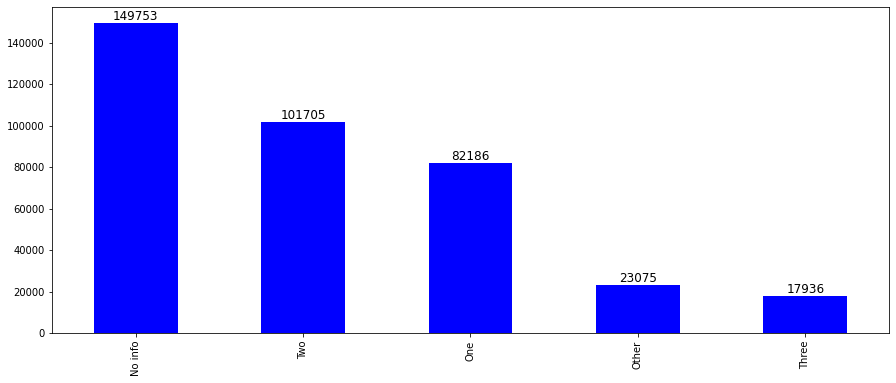

In [152]:
show_plot(data['stories'])

In [153]:
data_dict['stories'] = 'Перевести в КАТЕГОРИИ'

## mls-id 

In [154]:
show_info(data['mls-id'])

Сколько пропусков? 349718

Процент пропусков? 93.34400982236991%

Описание:
count       24937
unique      24902
top       No MLS#
freq            3
Name: mls-id, dtype: object

Как распределено?
NaN        349718
No              3
No MLS#         3
608063          2
19-3683         2
            ...  
19-3295         1
687932          1
1632430         1
3557147         1
2198556         1
Name: mls-id, Length: 24903, dtype: int64

Какие значения?
[nan '19221142' 'SR19195113' ... 'CV19260192' '7690588' 'F10202858']

Сколько уникальных?
24903


#### Просто ID, удалим 

In [155]:
data_dict['mls-id'] = 'Просто ID, необходимо УДАЛИТЬ'

## PrivatePool 

In [156]:
show_info(data['PrivatePool'])

Сколько пропусков? 334535

Процент пропусков? 89.29148149630994%

Описание:
count     40120
unique        2
top         yes
freq      28686
Name: PrivatePool, dtype: object

Как распределено?
NaN    334535
yes     28686
Yes     11434
Name: PrivatePool, dtype: int64

Какие значения?
[nan 'yes' 'Yes']

Сколько уникальных?
3


#### Зрительно видно, что баланс Nan и Yes 10:1, так что на границе можно дозволенного можно использовать колонку) 

In [157]:
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: str(x).lower())

def pool(pool):
    if pool == 'yes': return 'info available'
    else: return 'no info'
    
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: pool(x))    

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count      374655
unique          2
top       no info
freq       334535
Name: PrivatePool, dtype: object

Как распределено?
no info           334535
info available     40120
Name: PrivatePool, dtype: int64

Какие значения?
['no info' 'info available']

Сколько уникальных?
2



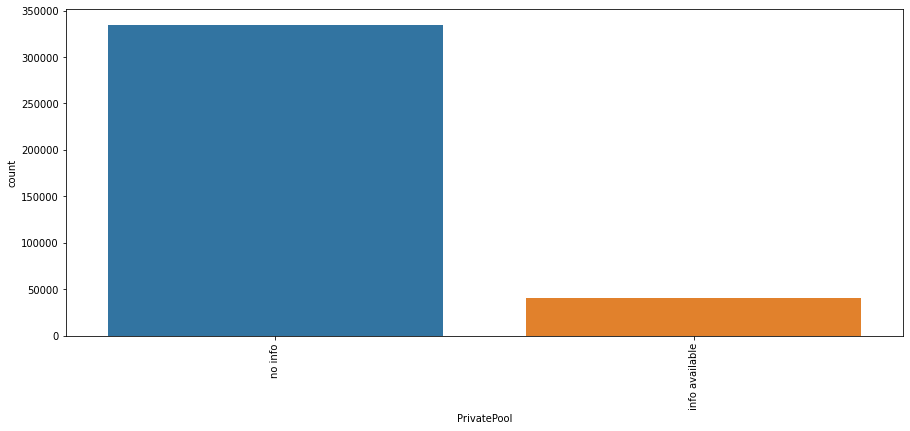

In [158]:
show_info_hist(data['PrivatePool'])

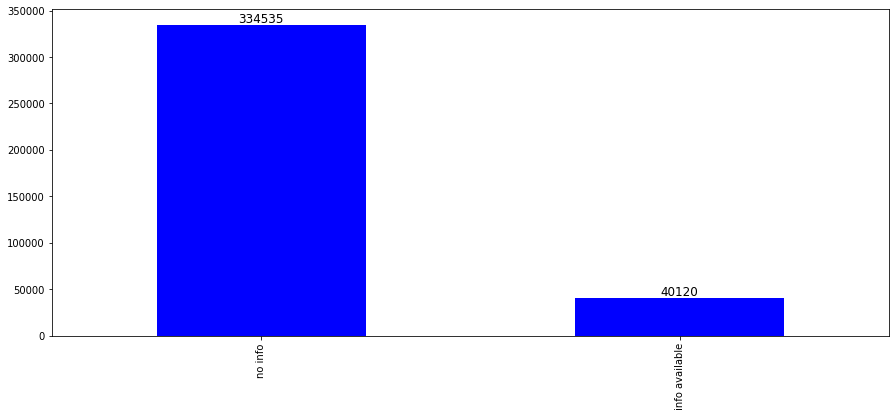

In [159]:
show_plot(data['PrivatePool'])

In [160]:
data_dict['PrivatePool'] = 'Загнать в КАТЕГОРИИ'

## MlsId 

In [161]:
show_info(data['MlsId'])

Сколько пропусков? 64468

Процент пропусков? 17.207297380256502%

Описание:
count     310187
unique    232876
top       NO MLS
freq          24
Name: MlsId, dtype: object

Как распределено?
NaN                        64468
NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
                           ...  
2147145                        1
14241190                       1
242600                         1
3527359                        1
57630516                       1
Name: MlsId, Length: 232877, dtype: int64

Какие значения?
['611019' '201916904' 'FR19221027' ... '2152007' '219049831' '10374233']

Сколько уникальных?
232877


#### Просто ID, удалим 

In [162]:
data_dict['MlsId'] = 'Просто ID, необходимо УДАЛИТЬ'

## target 

In [163]:
show_info(data['target'])

Сколько пропусков? 0

Процент пропусков? 0.0%

Описание:
count       374655
unique       43939
top       $225,000
freq          1462
Name: target, dtype: object

Как распределено?
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
            ... 
$404,131       1
$485,450       1
$311,957       1
$291,615       1
$61,050        1
Name: target, Length: 43939, dtype: int64

Какие значения?
['$418,000' '$310,000' '$2,895,000' ... '$815,881' '342,969' '$171,306']

Сколько уникальных?
43939


In [164]:
data['target'] = data['target'].apply(lambda x: str(x).replace('$',''))
data['target'] = data['target'].apply(lambda x: str(x).replace('+',''))
data['target'] = data['target'].apply(lambda x: str(x).replace(' - ',''))
data['target'] = data['target'].apply(lambda x: str(x).replace('-',''))
data['target'] = data['target'].apply(lambda x: str(x).replace('/mo','000'))
data['target'] = data['target'].apply(lambda x: str(x).replace('nan','225,000'))
data['target'] = data['target'].apply(lambda x: x.replace('27603-4374', '23229'))

In [165]:
def make_target(x):
    x = re.sub('[^0-9]', '', x)
    x = int(x)
    return x

data['target'] = data['target'].apply(make_target)
data['target'].describe

<bound method NDFrame.describe of 0          418000
1          310000
2         2895000
3         2395000
4            5000
           ...   
377180    1249000
377181     674999
377182     528000
377183      34500
377184     204900
Name: target, Length: 374655, dtype: int64>

In [166]:
# data['target'] = data['target'].apply(lambda x: locale.atoi(x))
# data['target'] = data['target'].astype('float')

In [167]:
data_dict['target'] = 'Целевая переменная'

# Итог EDA

### Не для всех колонок удалось придумать такой способо обработки, чтобы извлечь дополнительные данные. В некоторых колонках при разбиении данных на категории оставалась большая категория "Other". Часто число элементов в этой категории сильно превышает число элементов в других категориях, что не есть хорошо и требует более тщательного разбора соответствующей фичи. Для пары колонок с двумя категориями наблюдается разительное различие - дисбаланс по количеству элементов. Мной было принято решение все равно оставить эти колонки. 

In [168]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              374655 non-null  object 
 1   private pool        4151 non-null    object 
 2   propertyType        374655 non-null  object 
 3   street              374655 non-null  object 
 4   baths               269308 non-null  float64
 5   homeFacts           374655 non-null  object 
 6   fireplace           374655 non-null  object 
 7   city                374621 non-null  object 
 8   schools             374655 non-null  object 
 9   sqft                374655 non-null  float64
 10  zipcode             374655 non-null  object 
 11  beds                374655 non-null  object 
 12  state               374655 non-null  object 
 13  stories             374655 non-null  object 
 14  mls-id              24937 non-null   object 
 15  PrivatePool         374655 non-nul

In [169]:
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,status_rating,property_rating,num_prop_descr,street_t,street_type,num_bath,year_built,house_status,fireplace_mentions,city_rating,distance,distance_value,school_dist,num_schools_around,state_rating
0,active,NaN,single family home,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",something else,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",7.972811,28387,4,NC,No info,NaN,no info,611019,418000,active,family,3,'ln',LANE,>2,2019.0,new_house,1,min_pop_city,"[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...",1.877937,too far,8,pop_state
1,for sale,NaN,single-family home,12911 e heroy ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",other,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",7.574558,99216,3,WA,One,NaN,no info,201916904,310000,for sale,family,3,'ave',AVENUE,2,2019.0,new_house,1,min_pop_city,"[1.65mi, 1.32mi, 1.01mi]",0.845868,need_time,3,pop_state
2,for sale,NaN,single-family home,2005 westridge rd,2.0,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",available,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",8.006701,90049,3,CA,Two,NaN,info available,FR19221027,2895000,for sale,family,3,'rd',ROAD,2,1961.0,old_house,1,less_pop_city,"[1.19mi, 2.06mi, 2.63mi]",1.085189,need_time,3,pop_state
3,for sale,NaN,single-family home,4311 livingston ave,8.0,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",available,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",8.773075,75205,5,TX,Three,NaN,no info,14191809,2395000,for sale,family,3,'ave',AVENUE,>2,2006.0,modern_house,1,pop_city,"[1.05mi, 0.1mi, 1.05mi, 0.81mi]",0.559616,close,4,extra_pop_state
4,for sale,NaN,lot/land,1524 kiscoe st,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",other,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",6.908755,32908,6 or more,FL,No info,NaN,no info,861745,5000,for sale,Other,2,'st',STREET,>2,NaN,No info,1,min_pop_city,"[5.96mi, 3.25mi, 3.03mi]",1.625311,too far,3,extra_pop_state


In [170]:
#data_dict

In [171]:
cat_cols=[]
cols_to_drop=[]
num_cols=[]

cols_to_drop += ['status','private pool','propertyType','street','street_t','baths','homeFacts',
                'fireplace_mentions','city','schools','zipcode','state','mls-id','MlsId','year_built','dv','distance']
cat_cols += ['status_rating','property_rating','num_prop_descr','street_type','num_bath','fireplace',
            'city_rating','beds','state_rating','stories','PrivatePool', 'num_schools_around', 'house_status','school_dist']
num_cols += ['sqft','distance_value']

In [172]:
len(data.columns), len(cols_to_drop) + len(cat_cols) + len(num_cols)

(33, 33)

## Удалим указанные колонки, над остальными произведем преобразования

In [173]:
df = data.copy()

In [174]:
df.drop(['status','private pool','propertyType','street','street_t','baths','homeFacts',
                'fireplace_mentions','city','schools','zipcode','state','mls-id',
                 'MlsId','year_built','distance'], axis=1, inplace=True)

In [175]:
for colum in cat_cols:
    df[colum] = df[colum].astype('category').cat.codes
    
df.head(2)

,fireplace,sqft,beds,stories,PrivatePool,target,status_rating,property_rating,num_prop_descr,street_type,num_bath,house_status,city_rating,distance_value,school_dist,num_schools_around,state_rating
0,3,7.972811,3,0,1,418000,2,2,2,6,2,2,1,1.877937,3,7,2
1,2,7.574558,2,1,1,310000,3,2,2,1,0,2,1,0.845868,1,2,2


In [176]:
# fig, ax = plt.subplots(figsize=(10, 10))
# correlation = df[cat_cols].corr()
# sns.heatmap(correlation.abs(), annot=True, linewidth=1,  vmin=0, vmax=1, 
#             cmap='PuBuGn_r',  linewidths=1, linecolor='black')

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fireplace           374655 non-null  int8   
 1   sqft                374655 non-null  float64
 2   beds                374655 non-null  int8   
 3   stories             374655 non-null  int8   
 4   PrivatePool         374655 non-null  int8   
 5   target              374655 non-null  int64  
 6   status_rating       374655 non-null  int8   
 7   property_rating     374655 non-null  int8   
 8   num_prop_descr      374655 non-null  int8   
 9   street_type         374655 non-null  int8   
 10  num_bath            374655 non-null  int8   
 11  house_status        374655 non-null  int8   
 12  city_rating         374655 non-null  int8   
 13  distance_value      374655 non-null  float64
 14  school_dist         374655 non-null  int8   
 15  num_schools_around  374655 non-nul

In [178]:
df.sample(5)

,fireplace,sqft,beds,stories,PrivatePool,target,status_rating,property_rating,num_prop_descr,street_type,num_bath,house_status,city_rating,distance_value,school_dist,num_schools_around,state_rating
315227,2,6.988413,1,4,1,299900,0,0,0,6,0,1,2,1.835776,3,1,0
284539,2,6.668228,1,4,1,72059,0,2,1,7,1,4,2,0.524729,0,2,0
356878,2,7.419980,2,4,1,234900,2,2,2,2,0,3,2,1.015231,1,7,0
255831,2,6.502790,5,0,1,900000,3,1,0,7,2,4,0,2.036012,3,0,2
88272,2,7.376508,5,4,1,399000,2,0,0,7,1,4,1,1.376244,1,6,0


In [179]:
df.describe()

,fireplace,sqft,beds,stories,PrivatePool,target,status_rating,property_rating,num_prop_descr,street_type,num_bath,house_status,city_rating,distance_value,school_dist,num_schools_around,state_rating
count,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,3.746550e+05,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.000000,374655.00000
mean,1.600422,7.459834,3.097612,1.572017,0.892915,6.805796e+05,2.469787,1.622936,1.077901,6.558658,0.925353,2.078552,0.893977,1.137107,1.353520,3.026921,0.74184
std,0.817131,0.616200,1.529399,1.663960,0.309222,1.993732e+07,1.157512,1.150758,0.891790,2.548172,0.957865,1.383474,0.699790,0.581810,1.099847,2.078860,0.85568
min,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,6.943122,2.000000,0.000000,1.000000,1.880000e+05,2.000000,1.000000,0.000000,5.000000,0.000000,1.000000,0.000000,0.708036,1.000000,2.000000,0.00000
50%,2.000000,7.412764,3.000000,1.000000,1.000000,3.209900e+05,3.000000,2.000000,1.000000,7.000000,1.000000,2.000000,1.000000,1.011601,1.000000,2.000000,0.00000
75%,2.000000,7.807510,5.000000,4.000000,1.000000,5.850000e+05,3.000000,2.000000,2.000000,7.000000,2.000000,3.000000,1.000000,1.442202,3.000000,4.000000,2.00000
max,3.000000,20.495084,5.000000,4.000000,1.000000,1.215144e+10,6.000000,4.000000,3.000000,12.000000,2.000000,4.000000,2.000000,7.372640,3.000000,9.000000,2.00000


In [180]:
df.head(5)

,fireplace,sqft,beds,stories,PrivatePool,target,status_rating,property_rating,num_prop_descr,street_type,num_bath,house_status,city_rating,distance_value,school_dist,num_schools_around,state_rating
0,3,7.972811,3,0,1,418000,2,2,2,6,2,2,1,1.877937,3,7,2
1,2,7.574558,2,1,1,310000,3,2,2,1,0,2,1,0.845868,1,2,2
2,0,8.006701,2,4,0,2895000,3,2,2,9,0,3,0,1.085189,1,2,2
3,0,8.773075,4,3,1,2395000,3,2,2,1,2,1,2,0.559616,0,3,0
4,2,6.908755,5,0,1,5000,3,0,1,10,2,0,1,1.625311,3,2,0


In [181]:
#Экспериментальный датафрейм без dummy-переменных, пригодится в самом конце ноутбука
exp_df = df.copy()

#### Сделаем dummy-переменные 

In [182]:
df = pd.get_dummies(df, columns=['fireplace','beds','stories','PrivatePool','status_rating','property_rating',
                                'num_prop_descr','street_type','num_bath', 'city_rating','state_rating'] )

df

,sqft,target,house_status,distance_value,school_dist,num_schools_around,fireplace_0,fireplace_1,fireplace_2,fireplace_3,beds_0,beds_1,beds_2,beds_3,beds_4,beds_5,stories_0,stories_1,stories_2,stories_3,stories_4,PrivatePool_0,PrivatePool_1,status_rating_0,status_rating_1,status_rating_2,status_rating_3,status_rating_4,status_rating_5,status_rating_6,property_rating_0,property_rating_1,property_rating_2,property_rating_3,property_rating_4,num_prop_descr_0,num_prop_descr_1,num_prop_descr_2,num_prop_descr_3,street_type_0,street_type_1,street_type_2,street_type_3,street_type_4,street_type_5,street_type_6,street_type_7,street_type_8,street_type_9,street_type_10,street_type_11,street_type_12,num_bath_0,num_bath_1,num_bath_2,city_rating_0,city_rating_1,city_rating_2,state_rating_0,state_rating_1,state_rating_2
0,7.972811,418000,2,1.877937,3,7,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
1,7.574558,310000,2,0.845868,1,2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,8.006701,2895000,3,1.085189,1,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,8.773075,2395000,1,0.559616,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
4,6.908755,5000,0,1.625311,3,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,8.298540,1249000,1,1.036737,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
377181,7.601402,674999,4,0.693147,2,2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0
377182,7.050123,528000,4,0.683097,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
377183,6.908755,34500,0,0.470004,0,2,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0


In [183]:
df[num_cols]

,sqft,distance_value
0,7.972811,1.877937
1,7.574558,0.845868
2,8.006701,1.085189
3,8.773075,0.559616
4,6.908755,1.625311
...,...,...
377180,8.298540,1.036737
377181,7.601402,0.693147
377182,7.050123,0.683097
377183,6.908755,0.470004


# Готовим данные к ML

In [184]:
df.isna().sum()

sqft              0
target            0
house_status      0
distance_value    0
school_dist       0
                 ..
city_rating_1     0
city_rating_2     0
state_rating_0    0
state_rating_1    0
state_rating_2    0
Length: 61, dtype: int64

In [185]:
X = df.drop(['target'], axis=1)
y = df['target'].astype(float)
#y=np.log(y+1)

In [186]:
'''Сделаем разбиение на трейн, валидацию и тест
Трейн(train) - 70%
Валидация(val) - 15%
Тест(test) - 15%
Будем обучаться на трейне, калиброваться и тюнить на валидации, финал - проверка на тесте'''

X_train, X_to_test, y_train, y_to_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_to_test, y_to_test, test_size=0.5, random_state=RANDOM_SEED)

In [187]:
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [188]:
display(X_train[num_cols], X_val[num_cols], X_test[num_cols])

,sqft,distance_value
143792,0.365672,0.128028
325890,0.345852,0.208456
124407,0.355215,0.129603
228113,0.327744,0.085624
71615,0.386358,0.087059
...,...,...
260905,0.313889,0.038681
368301,0.368384,0.105705
132804,0.313889,0.140138
147831,0.313889,0.114148


,sqft,distance_value
30634,0.315673,0.201882
214510,0.360333,0.238897
227162,0.316061,0.133206
74159,0.333329,0.118179
348563,0.337668,0.094016
...,...,...
89268,0.314838,0.115890
245384,0.354768,0.174493
84670,0.369604,0.147649
139161,0.313889,0.136220


,sqft,distance_value
238863,0.364333,0.135223
69543,0.376039,0.087059
136018,0.322197,0.126969
106274,0.369987,0.146733
331853,0.313889,0.321492
...,...,...
360103,0.330722,0.185638
216881,0.341548,0.081968
34984,0.306748,0.142530
21380,0.324169,0.165989


In [189]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_train.shape

((262258, 60), (262258,), (56198, 60), (56198,), (56199, 60), (262258,))

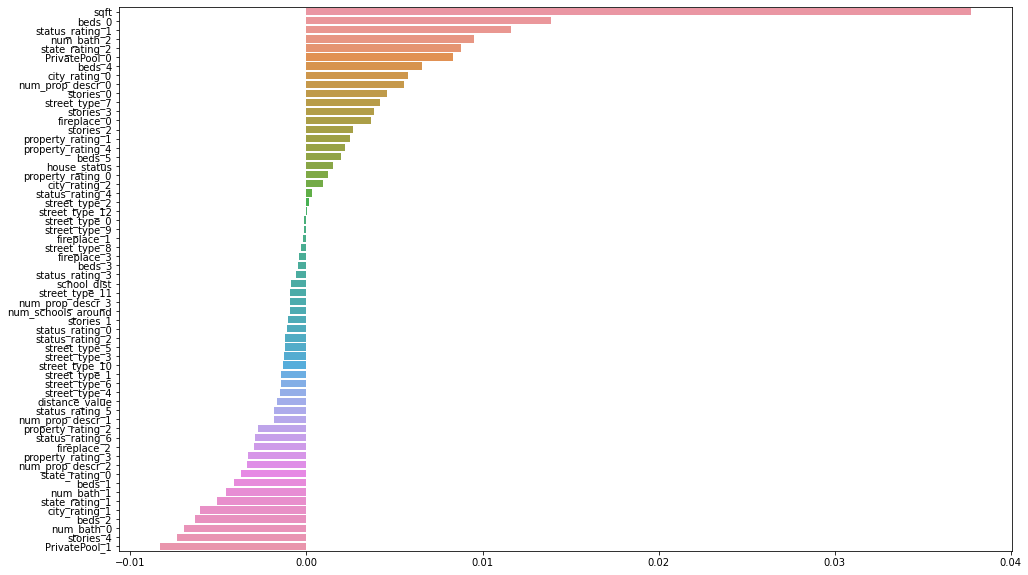

In [190]:
correlations = X_train.corrwith(y_train).sort_values(ascending=False)

plt.figure(figsize=(16, 10))

plot = sns.barplot(y=correlations.index, x=correlations)

In [191]:
'''Функция, которая выводит веса признаков для модели'''

def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

    
#show_weights(X.columns, model.coef_, X_train.std())

In [192]:
'''Чтобы постоянно не комментировать куски кода, которые уже отработали, я принудительно ставлю эту абракодабру, 
чтобы выдало ошибку и не исполняло следующие ячейки. После чего уже иду к тем ячейкам, которые нужны. По-хорошему,
наверное, так не делают. Просто ячейки из второй половины ноутбука могут работать и без части предыдущих - ML и NN 
не зависят друг от друга, только от обработки данных. Поэтому в коде иногда будут встречаться такие искусственные обрывы...'''
ччч

NameError: name 'ччч' is not defined

# Изучим различные модели для решения задачи РЕГРЕССИИ

In [193]:
'''Функция, считающая метрики.
На вход подаются (валидационные игреки, предсказанные угреки, трейновые игреки, предсказанный трейн)'''

def show_metrics(y_true_val, y_pred_val, y_true_train, y_pred_train):
    '''Посчитаем метрики'''
#     r2_val = r2_score(y_true_val, y_pred_val)
#     r2_train = r2_score(y_true_train, y_pred_train)
    mae_val = mean_absolute_error(y_true_val, y_pred_val)
    mae_train = mean_absolute_error(y_true_train, y_pred_train)
    mse_val = mean_squared_error(y_true_val, y_pred_val)
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    rmse_val = rmse(y_true_val, y_pred_val)
    rmse_train = rmse(y_true_train, y_pred_train)
    mape_val = mape(y_true_val, y_pred_val)
    mape_train = mape(y_true_train, y_pred_train)
    
    '''Выведем метрики'''
    print(f"Val MAE: {mae_val:0.2f}")
    print(f"Train MAE: {mae_train:0.2f}")
    print()
    print(f"Val MSE: {mse_val:0.2f}")
    print(f"Train MSE: {mse_train:0.2f}")
    print()
    print(f"Val RMSE: {rmse_val:0.2f}")
    print(f"Train RMSE: {rmse_train:0.2f}")
    print()
    print(f"Val MAPE: {mape_val:0.2f}")
    print(f"Train MAPE: {mape_train:0.2f}")
    print()
#     print(f"Val R2_score: {r2_val:0.3f}")
#     print(f"Train R2_score: {r2_train:0.3f}")
    
    '''Добавим метрики в списки'''
    mae_val_list.append(mae_val)
    mae_train_list.append(mae_train)
    mse_val_list.append(mse_val)
    mse_train_list.append(mse_train)
    rmse_val_list.append(rmse_val)
    rmse_train_list.append(rmse_train)
    mape_val_list.append(mape_val)
    mape_train_list.append(mape_train)
    
'''r2_score скорректированное'''    
def r2_adj(model, name):
    
    # r2_score
    r2_val = model.score(X_val, np.log(y_val))
    r2_train = model.score(X_train, np.log(y_train))
    print('R2_score  - val/train: ',round(r2_val,4), round(r2_train,4)) 
    
    # r2-скорректированное
    r2_val_adj = 1 - (1-r2_val)*(len(y_val)-1)/(len(y_val)-X_val.shape[1]-1)
    r2_train_adj = 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
    print('R2_score_adjusted - val/train: ', round(r2_val_adj,4), round(r2_train_adj,4))  
    
    #Добавим всё в списки
    r2_val_list.append(r2_val)
    r2_train_list.append(r2_train)
    r2_val_adj_list.append(r2_val_adj)
    r2_train_adj_list.append(r2_train_adj)
    model_name_list.append(name)

In [194]:
'''Необходимые списки, чтобы хранить результаты'''
model_name_list=[]
mae_val_list = []; mae_train_list = []
mse_val_list = []; mse_train_list = []
rmse_val_list = []; rmse_train_list = []
mape_val_list = []; mape_train_list= []    
r2_val_list = []; r2_train_list = []
r2_val_adj_list = []; r2_train_adj_list = []

### *В качестве некоего baseline будем предсказывать некую константу во всех случаях.*  

# Предскажем среднее

In [195]:
'''Я решил использовать среднее значение таргета по трейновой выборке'''
y_pred_naive = y_train.mean()
y_pred_naive

699149.5185695003

In [196]:
y_val_pred_list = [y_pred_naive for x in range(len(y_val))]
y_train_pred_list = [y_pred_naive for x in range(len(y_train))]

len(y_val_pred_list), len(y_train_pred_list)

(56198, 262258)

In [197]:
mae_naive = mean_absolute_error(y_val, y_val_pred_list)
mae_naive = mean_absolute_error(y_train, y_train_pred_list)
mse_naive = mean_squared_error(y_val, y_val_pred_list)
mse_naive = mean_squared_error(y_train, y_train_pred_list)
    
print(f"Val MAE: {mae_naive:0.2f}")
print(f"Train MAE: {mae_naive:0.2f}")
print()
print(f"Val MSE: {mse_naive:0.2f}")
print(f"Train MSE: {mse_naive:0.2f}")
print()

Val MAE: 665169.76
Train MAE: 665169.76

Val MSE: 566691731381725.62
Train MSE: 566691731381725.62



#### Это будет наш бейзлайн, который постараемся побить 

# LinearRegression

In [198]:
%%time

lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, np.log(y_train))
predict_lr_val = lr.predict(X_val)
predict_lr_val = np.exp(predict_lr_val)
predict_lr_train = lr.predict(X_train)
predict_lr_train = np.exp(predict_lr_train)


CPU times: user 555 ms, sys: 139 ms, total: 694 ms
Wall time: 785 ms


In [199]:
show_metrics(y_val, predict_lr_val, y_train, predict_lr_train)
print()
r2_adj(lr, 'LinearRegression')

Val MAE: 415200.32
Train MAE: 507810.65

Val MSE: 2698562520345.86
Train MSE: 654760297950928.38

Val RMSE: 1642730.20
Train RMSE: 25588284.39

Val MAPE: 1520.85
Train MAPE: 895.55


R2_score  - val/train:  0.38 0.3836
R2_score_adjusted - val/train:  0.3793 0.3834


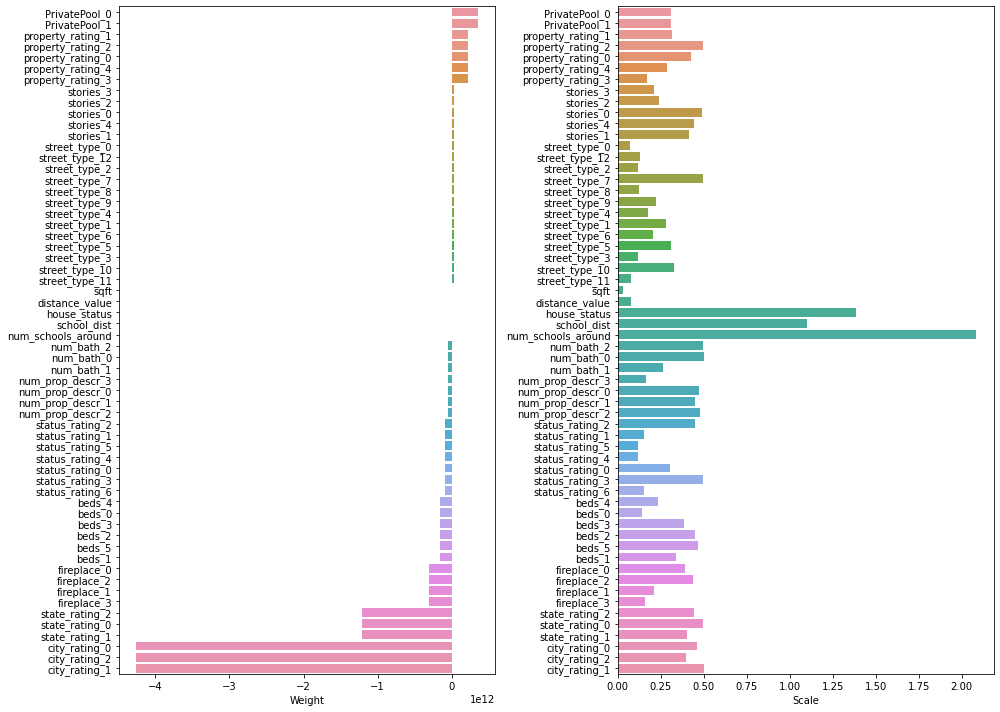

In [200]:
show_weights(X.columns, lr.coef_, X_train.std())

# RandomForest

In [201]:
%%time

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, np.log(y_train))
predict_rf_val = rf.predict(X_val)
predict_rf_val = np.exp(predict_rf_val)
predict_rf_train = rf.predict(X_train)
predict_rf_train = np.log(predict_rf_train)

show_metrics(y_val, predict_rf_val,y_train, predict_rf_train )
print()
r2_adj(rf, 'RandomForestRegressor')

Val MAE: 287314.58
Train MAE: 699146.99

Val MSE: 1276018068443.21
Train MSE: 567180537707667.88

Val RMSE: 1129609.70
Train RMSE: 23815552.43

Val MAPE: 1207.05
Train MAPE: 100.00


R2_score  - val/train:  0.6277 0.9289
R2_score_adjusted - val/train:  0.6273 0.9289
CPU times: user 4min 36s, sys: 1.22 s, total: 4min 38s
Wall time: 4min 39s


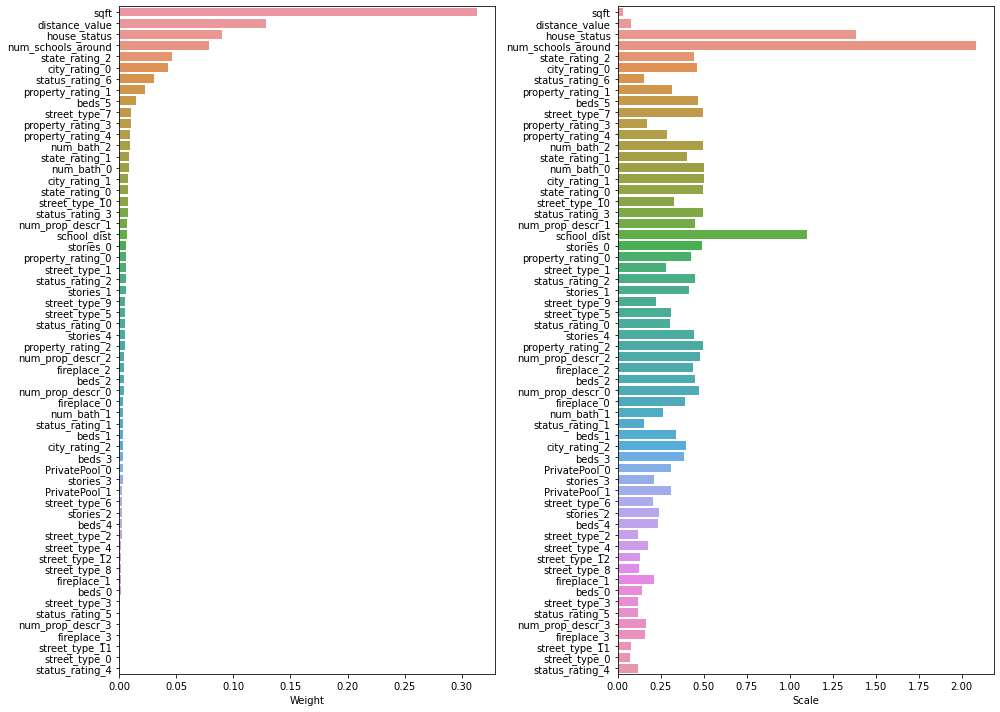

In [202]:
show_weights(X.columns, rf.feature_importances_, X_train.std())

In [203]:
%%time

rf_t = RandomForestRegressor(max_depth=110, min_samples_split=10, min_samples_leaf = 5, max_features='auto',\
                           bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)
rf_t.fit(X_train, np.log(y_train))
predict_rf_t_val = rf_t.predict(X_val)
predict_rf_t_val = np.exp(predict_rf_t_val)
predict_rf_t_train = rf_t.predict(X_train)
predict_rf_t_train = np.log(predict_rf_t_train)

show_metrics(y_val, predict_rf_t_val,y_train, predict_rf_t_train )
print()
r2_adj(rf_t, 'RandomForestRegressor_tune1')

Val MAE: 287354.23
Train MAE: 699146.98

Val MSE: 1297943822276.65
Train MSE: 567180537751261.75

Val RMSE: 1139273.37
Train RMSE: 23815552.43

Val MAPE: 1001.36
Train MAPE: 100.00


R2_score  - val/train:  0.6504 0.7941
R2_score_adjusted - val/train:  0.6501 0.794
CPU times: user 5min 23s, sys: 735 ms, total: 5min 24s
Wall time: 2min 53s


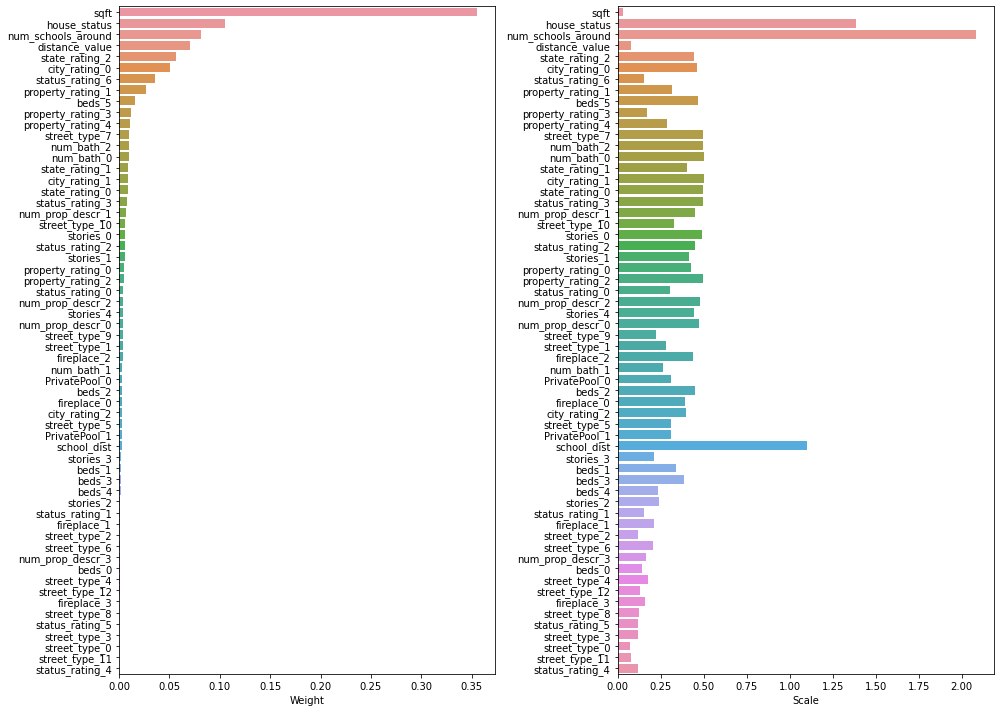

In [204]:
show_weights(X.columns, rf_t.feature_importances_, X_train.std())

In [205]:
'''RandomizedSearchCV из учебных материалов - час спустя убил весь ноутбук с ошибкой памяти'''
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train, y_train)
# # Посмотрим, какие гиперпараметры нам предлагают как оптимальные:
# rf_random.best_params_

'RandomizedSearchCV из учебных материалов - час спустя убил весь ноутбук с ошибкой памяти'

# GradientBoosting

In [206]:
%%time

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, np.log(y_train))
predict_gb_val = gb.predict(X_val)
predict_gb_val = np.exp(predict_gb_val)
predict_gb_train = gb.predict(X_train)
predict_gb_train = np.exp(predict_gb_train)

show_metrics(y_val, predict_gb_val, y_train, predict_gb_train)
print()
r2_adj(gb, 'GradientBoostingRegressor')

Val MAE: 340477.50
Train MAE: 402702.96

Val MSE: 1713471478546.78
Train MSE: 565229353380427.25

Val RMSE: 1308996.36
Train RMSE: 23774552.64

Val MAPE: 1627.56
Train MAPE: 905.84


R2_score  - val/train:  0.5391 0.5488
R2_score_adjusted - val/train:  0.5386 0.5487
CPU times: user 53.7 s, sys: 164 ms, total: 53.9 s
Wall time: 54.1 s


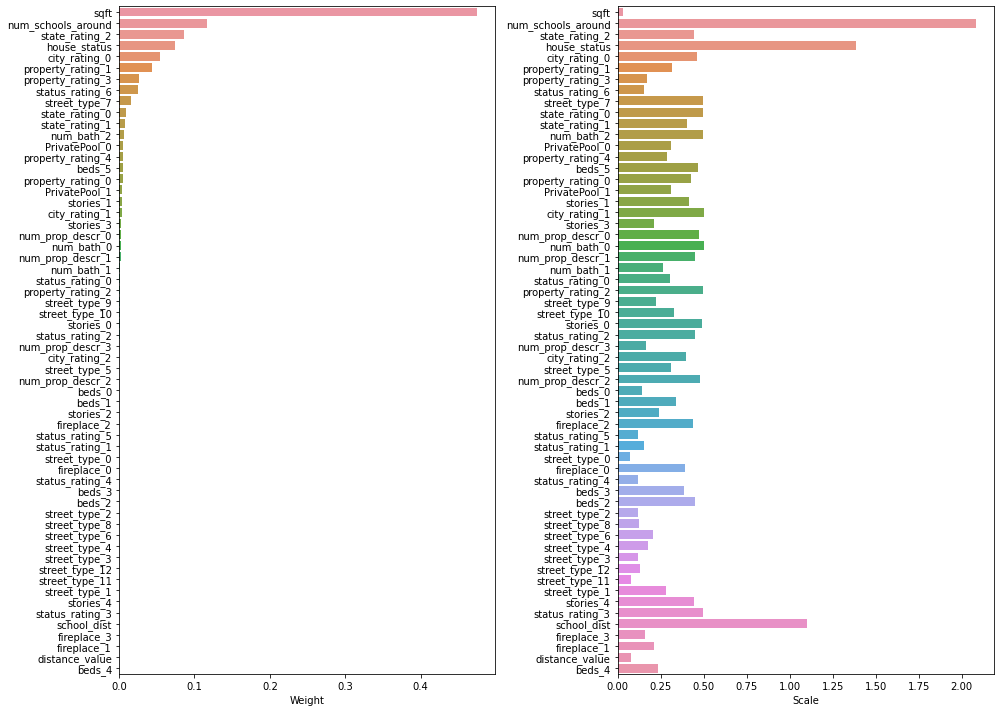

In [207]:
show_weights(X.columns, gb.feature_importances_, X_train.std())

In [208]:
%%time

# gb = GradientBoostingRegressor(n_estimators=100, criterion='mae', min_samples_split=10, \
#                                min_samples_leaf=5,max_depth=5, max_features='auto', random_state=42)
gb_t = GradientBoostingRegressor(max_depth=15, min_samples_leaf=15,  min_samples_split=10, max_features='auto', random_state=42)
gb_t.fit(X_train, np.log(y_train))
predict_gb_t_val = gb_t.predict(X_val)
predict_gb_t_val = np.exp(predict_gb_t_val)
predict_gb_t_train = gb_t.predict(X_train)
predict_gb_t_train = np.exp(predict_gb_t_train)

show_metrics(y_val, predict_gb_t_val, y_train, predict_gb_t_train)
print()
r2_adj(gb_t, 'GradientBoostingRegressor_tune')


Val MAE: 278216.44
Train MAE: 280041.38

Val MSE: 1238824496015.33
Train MSE: 558730499746879.19

Val RMSE: 1113024.93
Train RMSE: 23637480.82

Val MAPE: 820.62
Train MAPE: 105.24


R2_score  - val/train:  0.6715 0.7759
R2_score_adjusted - val/train:  0.6711 0.7758
CPU times: user 4min 16s, sys: 289 ms, total: 4min 16s
Wall time: 4min 17s


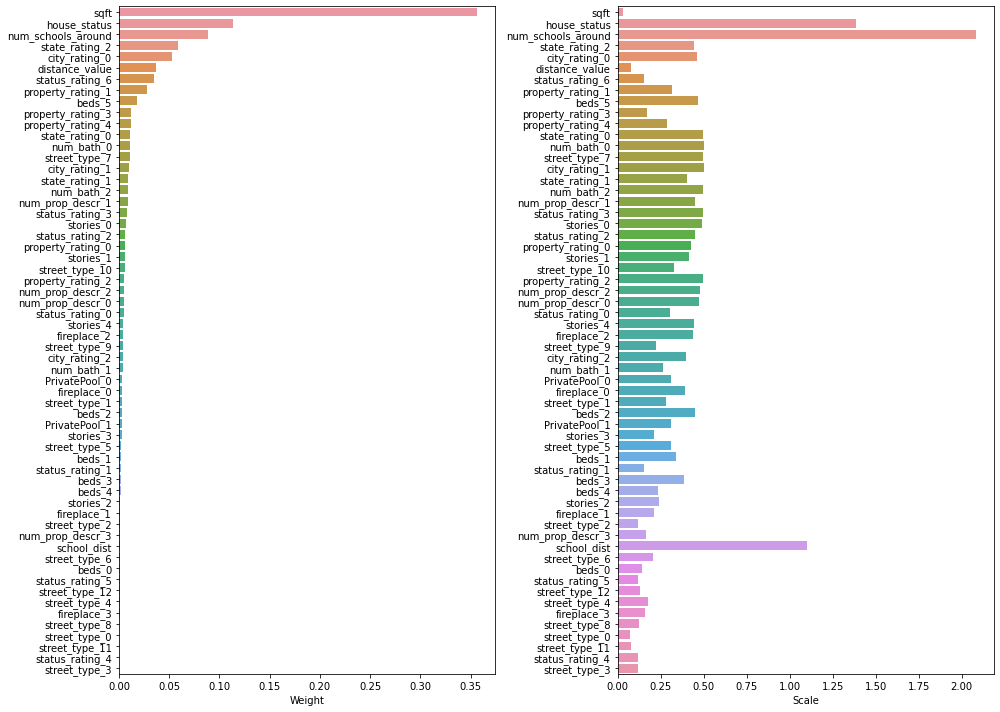

In [209]:
show_weights(X.columns, gb_t.feature_importances_, X_train.std())

# CatBoost 

In [210]:
%%time


ctb = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
ctb.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_val, np.log(y_val)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

#model.save_model('catboost_single_model_baseline.model')
predict_ctb_val = ctb.predict(X_val)
predict_ctb_val = np.exp(predict_ctb_val)
predict_ctb_train = ctb.predict(X_train)
predict_ctb_train = np.exp(predict_ctb_train)

CPU times: user 6min 24s, sys: 6.08 s, total: 6min 30s
Wall time: 3min 26s


In [211]:
show_metrics(y_val, predict_ctb_val, y_train, predict_ctb_train)
print()
r2_adj(ctb, 'CatBoostRegressor')

Val MAE: 287054.70
Train MAE: 317061.07

Val MSE: 1335827030821.44
Train MSE: 303622782301078.38

Val RMSE: 1155779.84
Train RMSE: 17424774.96

Val MAPE: 586.72
Train MAPE: 199.04


R2_score  - val/train:  0.6707 0.7054
R2_score_adjusted - val/train:  0.6703 0.7053


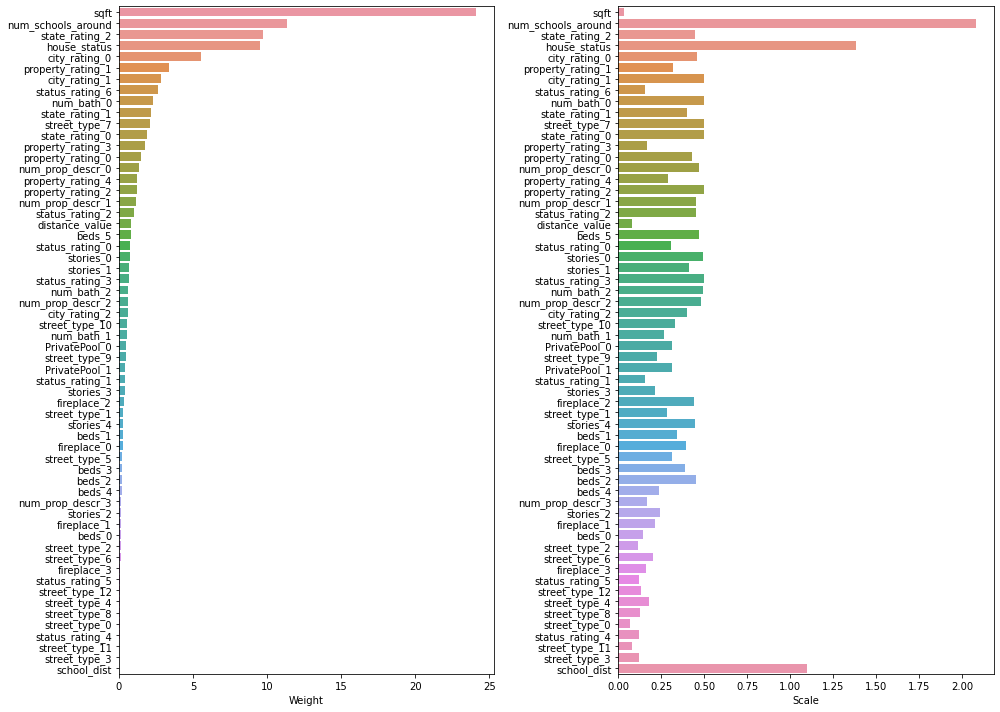

In [212]:
show_weights(X.columns, ctb.feature_importances_, X_train.std())

### Обучение моделей закончено, соберем информацию в 1 датафрейм для наглядности 

In [213]:
feat_full=pd.DataFrame(index=model_name_list)
feat_full['mae_val'] = mae_val_list
feat_full['mae_train'] = mae_train_list
feat_full['mse_val'] = mse_val_list
feat_full['mse_train'] = mse_train_list
feat_full['r2_val'] = r2_val_list
feat_full['r2_train'] = r2_train_list
feat_full['r2_val_adj'] = r2_val_list
feat_full['r2_train_adj'] = r2_train_list
feat_full['rmse_val'] = rmse_val_list
feat_full['rmse_train'] = rmse_train_list
feat_full['mape_val'] = mape_val_list
feat_full['mape_train'] = mape_train_list

feat_full

,mae_val,mae_train,mse_val,mse_train,r2_val,r2_train,r2_val_adj,r2_train_adj,rmse_val,rmse_train,mape_val,mape_train
LinearRegression,415200.318471,507810.653159,2.698563e+12,6.547603e+14,0.379999,0.383553,0.379999,0.383553,1.642730e+06,2.558828e+07,1520.847289,895.553697
RandomForestRegressor,287314.581215,699146.985068,1.276018e+12,5.671805e+14,0.627691,0.928901,0.627691,0.928901,1.129610e+06,2.381555e+07,1207.050971,99.995024
RandomForestRegressor_tune1,287354.228922,699146.984524,1.297944e+12,5.671805e+14,0.650440,0.794052,0.650440,0.794052,1.139273e+06,2.381555e+07,1001.361285,99.998438
GradientBoostingRegressor,340477.498101,402702.957774,1.713471e+12,5.652294e+14,0.539109,0.548803,0.539109,0.548803,1.308996e+06,2.377455e+07,1627.560774,905.835291
GradientBoostingRegressor_tune,278216.442753,280041.381419,1.238824e+12,5.587305e+14,0.671474,0.775875,0.671474,0.775875,1.113025e+06,2.363748e+07,820.617209,105.235113
CatBoostRegressor,287054.700251,317061.069562,1.335827e+12,3.036228e+14,0.670700,0.705365,0.670700,0.705365,1.155780e+06,1.742477e+07,586.721412,199.041367


In [214]:
'''Попробовал сделать настройку случайного леса через optuna - очень долго считало, вылетев с ошибкой памяти'''
# %%time

# def objective(trial):
#     criterion = trial.suggest_categorical('criterion', ['mse', 'mae'])
#     bootstrap = trial.suggest_categorical('bootstrap',['True','False'])
#     max_depth = trial.suggest_int('max_depth', 1, 100)
#     max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt','log2'])
#     max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 1, 100)
#     n_estimators =  trial.suggest_int('n_estimators', 3, 100)
    
#     regr = RandomForestRegressor(bootstrap = bootstrap, criterion = criterion,
#                                  max_depth = max_depth, max_features = max_features,
#                                  max_leaf_nodes = max_leaf_nodes,n_estimators = n_estimators,n_jobs=2)
    
    
#     regr.fit(X_train, y_train)
#     y_pred = regr.predict(X_val)
#     return r2_score(y_val, y_pred)
    
#     score = cross_val_score(regr, X_train, y_train, cv=5, scoring="r2")
#     r2_mean = score.mean()

#     return r2_mean
# #Execute optuna and set hyperparameters
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=3)

# #Create an instance with tuned hyperparameters
# optimised_rf = RandomForestRegressor(bootstrap = study.best_params['bootstrap'], criterion = study.best_params['criterion'],
#                                      max_depth = study.best_params['max_depth'], max_features = study.best_params['max_features'],
#                                      max_leaf_nodes = study.best_params['max_leaf_nodes'],n_estimators = study.best_params['n_estimators'],
#                                      n_jobs=2)
# #learn
# optimised_rf.fit(X_train ,y_train)
# predict_opt_rf_val = optimized_rd.predict(X_val)
# predict_opt_rf_val = np.exp(predict_opt_rf_val)
# predict_opt_rf_train = optimized_rd.predict(X_train)
# predict_opt_rf_train = np.exp(predict_opt_rf_train)

# show_metrics(y_val, predict_opt_rf_val, y_train, predict_opt_rf_train)
# print()
# r2_adj(ctb)

'Попробовал сделать настройку случайного леса через optuna - очень долго считало, вылетев с ошибкой памяти'

In [215]:
from sklearn.model_selection import cross_val_score
all_scores_lr=cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
all_scores_rf=cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
all_scores_rf_t=cross_val_score(rf_t, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
all_scores_gb=cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
all_scores_gb_t=cross_val_score(gb_t, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [216]:
print('LR: MAE mean on cv: {}, MAE std on cv: {}'.format(all_scores_lr.mean(), all_scores_lr.std()))
print('RF: MAE mean on cv: {}, MAE std on cv: {}'.format(all_scores_rf.mean(), all_scores_rf.std()))
print('RF_tuned: MAE mean on cv: {}, MAE std on cv: {}'.format(all_scores_rf_t.mean(), all_scores_rf_t.std()))
print('GB: MAE mean on cv: {}, MAE std on cv: {}'.format(all_scores_gb.mean(), all_scores_gb.std()))
print('GB_tuned: MAE mean on cv: {}, MAE std on cv: {}'.format(all_scores_gb_t.mean(), all_scores_gb_t.std()))

LR: MAE mean on cv: -864075.7519246932, MAE std on cv: 33958.71914861605
RF: MAE mean on cv: -408831.79773737706, MAE std on cv: 90687.14309923016
RF_tuned: MAE mean on cv: -435662.79877523554, MAE std on cv: 73955.04917675698
GB: MAE mean on cv: -476817.7214762998, MAE std on cv: 91897.5583510026
GB_tuned: MAE mean on cv: -434731.346218592, MAE std on cv: 76983.71651221975


In [217]:
import lightgbm as lgm
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [218]:
model = lgm.LGBMRegressor()
# evaluate the model
#cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE mean: %.3f, MAE std: %.3f' % (n_scores.mean(), n_scores.std()))

MAE mean: -536056.830, MAE std: 33867.738


In [219]:
model = CatBoostRegressor()
# evaluate the model
#cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
cv = KFold(n_splits=5, random_state=1, shuffle=True)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE std: %.3f, MAE std: %.3f' % (n_scores.mean(), n_scores.std()))

MAE std: -431180.707, MAE std: 79398.217


# Рефлексия по Clas ML

* Данные очищены, пропуски заполнялись на самое популярное значение в колонке, на среднее значение по колонке, а также переводились в собственную категорию ('nan', 'no info', etc.)
* Проведен анализ с использованием dummy-переменных и без них
* Среди многих моделей для решения задачи регрессии были отобраны 4 основные:

    1. Линейная регрессия
    2. Случайный лес
    3. Градиентный бустинг
    4. CatBoost
    
* Опробованы разные скейлеры - разница минимальная        
* Для моделей проводилась более тонкая настройка гиперпараметров
* По совокупности метрик лучшего всего себя показали:

    1. CatBoost
    2. GradientBoosting (tuned)
    
* Используем обе для предсказания на тестовых данных    

# Предсказания на тесте

In [220]:
def show_metrics_on_test(y_true_test, y_pred_test, model):
    '''Посчитаем метрики'''
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mse_test = mean_squared_error(y_true_test, y_pred_test)
    rmse_test = rmse(y_true_test, y_pred_test)
    mape_test = mape(y_true_test, y_pred_test)
    r2_test = model.score(X_test, np.log(y_test))
    r2_test_adj = 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    
    '''Выведем метрики'''
    print(f"Test MAE: {mae_test:0.2f}")
    print(f"Test MSE: {mse_test:0.2f}")
    print(f"Test RMSE: {rmse_test:0.2f}")
    print(f"Test MAPE: {mape_test:0.2f}")
    print(f"Test R2: {r2_test:0.3f}")
    print(f"Test R2_adj: {r2_test_adj:0.3f}")

In [221]:
'''Предсказание на основе настроенного Градиентного бустинга'''
predict_gb_test = gb_t.predict(X_test)
predict_gb_test = np.exp(predict_gb_test)
show_metrics_on_test(y_test, predict_gb_test, gb_t)

Test MAE: 281146.16
Test MSE: 1656719636912.78
Test RMSE: 1287136.22
Test MAPE: 257.35
Test R2: 0.678
Test R2_adj: 0.678


In [222]:
'''Предсказание на основе CatBoost'''
predict_ctb_test = ctb.predict(X_test)
predict_ctb_test = np.exp(predict_ctb_test)
show_metrics_on_test(y_test, predict_ctb_test, ctb)

Test MAE: 285252.17
Test MSE: 1693056482004.13
Test RMSE: 1301175.04
Test MAPE: 154.74
Test R2: 0.678
Test R2_adj: 0.677


#### Очень близкие по своим финальным результатам модели. По МАЕ слегка предпочтительнее смотрится GradientBoosting, по метрике MAPE лидирует CatBoost. 
* Если мы говорим с экономистами, им более понятна MAPE
* Если важно получить выгоду и речь непосредственно о тысячах долларах, то используем MAE

# **Нейронная сеть**

### **Посмотрим на процесс обучения одной из моделей** 

Epoch 1/20
13113/13113 [==============================] - 33s 2ms/step - loss: 78700097766008.7969 - mae: 553887.1066 - val_loss: 2701145931776.0000 - val_mae: 505776.2500
Epoch 2/20
13113/13113 [==============================] - 32s 2ms/step - loss: 253044267497513.5312 - mae: 518914.3212 - val_loss: 2657134051328.0000 - val_mae: 524833.8125
Epoch 3/20
13113/13113 [==============================] - 32s 2ms/step - loss: 454707964292820.1250 - mae: 543937.2954 - val_loss: 2576619667456.0000 - val_mae: 465199.7188
Epoch 4/20
13113/13113 [==============================] - 31s 2ms/step - loss: 147102053931300.6562 - mae: 484502.2626 - val_loss: 2507150458880.0000 - val_mae: 478451.5000
Epoch 5/20
13113/13113 [==============================] - 32s 2ms/step - loss: 15397591776105.6094 - mae: 462654.7277 - val_loss: 2426605404160.0000 - val_mae: 453206.8125
Epoch 6/20
13113/13113 [==============================] - 32s 2ms/step - loss: 78375409542677.9375 - mae: 467582.5790 - val_loss: 2396408

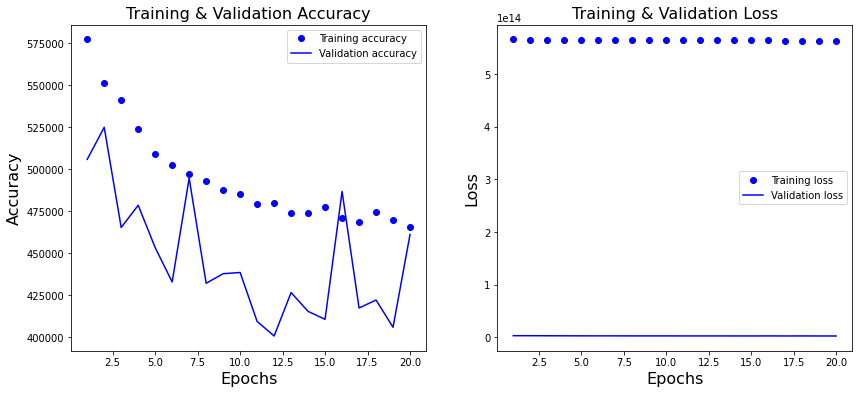

In [223]:
%%time

'''Функция, в которой мы руками строим модель, задавая слои'''
def build_model():
    model  = M.Sequential()
    model.add(L.Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(64, activation='relu'))
    model.add(L.Dense(32, activation='relu'))
    model.add(L.Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

nnr=build_model()

'''Обучение'''
history = nnr.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=20)

#import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['mae']
val_accuracy = history_dict['val_mae']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy (MAE) vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

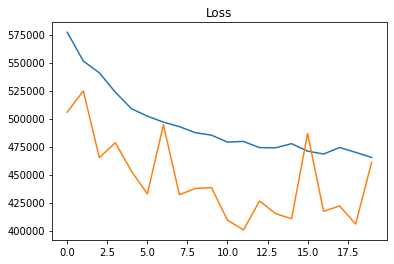

In [224]:
plt.title('Loss')
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.show();

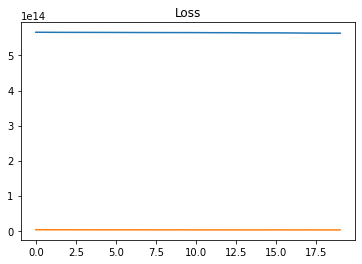

In [225]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.show();

### Работает, можно провести более серьезную подготовку 

In [226]:
'''Списки под параметры экземпяра класса и метрики'''
#метрики
r2_test_lst = []; r2_train_lst = []
mae_test_lst = []; mae_train_lst = []
mse_test_lst = []; mse_train_lst = []

#слои
l1_lst = []; l2_lst = []; l3_lst = []; l4_lst = []

#Имя модели
model_names_lst = []

'''Зададим инициализацию'''
init_1 = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=12345)
init_2 = initializers.Constant(value=1e-3)
init_3 = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=123456)

In [227]:
class TryModel:
    
    '''Инициализация слоев, способа активации, имя модели и "простота модели" '''
    def __init__(self, layer1, layer2, layer3, layer4, activation1, activation2, model_name, simple):
        self.__layer1 = layer1
        self.__layer2 = layer2
        self.__layer3 = layer3
        self.__layer4 = layer4
        self.__activation1 = activation1
        self.__activation2 = activation2
        self.__model_name = model_name
        self.__simple = simple
        
    '''Сохраним в списки введенные параметры модели'''
    def save_model_params(self):
        l1_lst.append(self.__layer1)
        l2_lst.append(self.__layer2)
        l3_lst.append(self.__layer3)
        l4_lst.append(self.__layer4)
        model_names_lst.append(self.__model_name)
        print('Параметры модели успешно сохранены')
        
        
    '''Строим и обучаем модель, получаем предикты'''
    def build_model(self):
        
        if self.__simple == 0:
            '''Зададим модель'''
            model = M.Sequential()
            model.add(L.Dense(self.__layer1, activation=self.__activation1, input_shape=(X_train.shape[1],)))
            model.add(L.Dense(self.__layer2, activation=self.__activation1))
            model.add(L.Dense(self.__layer3, activation=self.__activation1))
            model.add(L.Dense(self.__layer4, activation=self.__activation1))
            model.add(L.Dense(1, activation=self.__activation2))
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            #return model
            model.summary()
            self.model = model
            print('Модель успешно создана')
        
            '''Обучим модель и сделаем предикты'''
            model.fit(X_train, np.log(y_train+1), verbose=1)
            
            pred_test = model.predict(X_val)
            pred_test = np.exp(pred_test)
            pred_train = model.predict(X_train)
            pred_train = np.exp(pred_train)
            self.__pred_test = pred_test
            self.__pred_train = pred_train
            K.clear_session()
            print('Модель успешно обучена')
            
        elif self.__simple == 1:
            '''Зададим модель'''
            model = M.Sequential()
            model.add(L.Dense(self.__layer1, activation=self.__activation1, input_shape=(X_train.shape[1],)))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer2, activation=self.__activation1))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer3, activation=self.__activation1))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer4, activation=self.__activation1))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(1, activation=self.__activation2))
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            #return model
            model.summary()
            self.model = model
            print('Модель успешно создана')
            
            '''Обучим модель и сделаем предикты'''
            model.fit(X_train, np.log(y_train), verbose=1)
            
            pred_test = model.predict(X_val)
            pred_test = np.exp(pred_test)
            pred_train = model.predict(X_train)
            pred_train = np.exp(pred_train)
            self.__pred_test = pred_test
            self.__pred_train = pred_train
            K.clear_session()
            print('Модель успешно обучена')
            
        elif self.__simple == 2:
            '''Зададим модель'''
            model = M.Sequential()
            model.add(L.Dense(self.__layer1, activation=self.__activation1, input_shape=(X_train.shape[1],), kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer2, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer3, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(self.__layer4, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dropout(0.2))
            model.add(L.Dense(1, activation=self.__activation2))
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            #return model
            model.summary()
            self.model = model
            print('Модель успешно создана')
            
            '''Обучим модель и сделаем предикты'''
            model.fit(X_train, np.log(y_train+1), verbose=1)
            
            pred_test = model.predict(X_val)
            pred_test = np.exp(pred_test)
            pred_train = model.predict(X_train)
            pred_train = np.exp(pred_train)
            self.__pred_test = pred_test
            self.__pred_train = pred_train
            K.clear_session()
            print('Модель успешно обучена')
            
        elif self.__simple == 3:   
            '''Зададим модель'''
            model = M.Sequential()
            model.add(L.Dense(self.__layer1, activation=self.__activation1, input_shape=(X_train.shape[1],), kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dense(self.__layer2, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dense(self.__layer3, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dense(self.__layer4, activation=self.__activation1, kernel_initializer=init_1,
                      bias_initializer=init_2))
            model.add(L.Dense(1, activation=self.__activation2))
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            #return model
            model.summary()
            self.model = model
            print('Модель успешно создана')
            
            '''Обучим модель и сделаем предикты'''
            model.fit(X_train, np.log(y_train), verbose=1)
            
            pred_test = model.predict(X_val)
            pred_test = np.exp(pred_test)
            pred_train = model.predict(X_train)
            pred_train = np.exp(pred_train)
            self.__pred_test = pred_test
            self.__pred_train = pred_train
            K.clear_session()
            print('Модель успешно обучена')
            
        else:
            print('Что-то пошло не так')
        
    '''Вывод метрик'''    
    def show_metrics(self):
        print('r2_score on test:', round(r2_score(y_val, self.__pred_test)*100,3))
        print('r2_score on train:', round(r2_score(y_train, self.__pred_train)*100,3))  
        print('mae on test:', round(mean_absolute_error(y_val, self.__pred_test)*100,3))
        print('mae on train:', round(mean_absolute_error(y_train, self.__pred_train)*100,3))
        print('mse on test:', round(mean_squared_error(y_val, self.__pred_test)*100,3))
        print('mse on train:', round(mean_squared_error(y_train, self.__pred_train)*100,3))
#         print('rmse on test:', round(rmse(y_test, self.__pred_test)*100,3))
#         print('rmse on train:', round(rmse(y_train, self.__pred_train)*100,3))
#         print('mape on test:', round(mape(y_test, self.__pred_test)*100,3))
#         print('mape on train:', round(mape(y_train, self.__pred_train)*100,3))    
        
    '''Сохраняем метрики в списки'''    
    def save_metrics(self ):
        r2_test_lst.append(round(r2_score(y_val, self.__pred_test)*100,3))
        r2_train_lst.append(round(r2_score(y_train, self.__pred_train)*100,3))
        mae_test_lst.append(round(mean_absolute_error(y_val, self.__pred_test)*100,3))
        mae_train_lst.append(round(mean_absolute_error(y_train, self.__pred_train)*100,3))
        mse_test_lst.append(round(mean_squared_error(y_val, self.__pred_test)*100,3))
        mse_train_lst.append(round(mean_squared_error(y_train, self.__pred_train)*100,3))
        print('Метрики {r2, mae, mse}  на тесте и трейне успешно добавлены')
    
    '''Визуализация обучения'''
    def plot_history(self):
        history = self.model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=20)
        plt.title('Loss')
        plt.plot(history.history['mae'], label='train')
        plt.plot(history.history['val_mae'], label='test')
        plt.show();
        plt.title('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.show();


In [228]:
#Создадим экземпляр класса
model1 = TryModel(512,256,256,64,'relu','linear', 'model_1',1)

#Воспользуемся методами класса
model1.build_model()
model1.show_metrics()
model1.save_metrics()
model1.save_model_params()
#model1.plot_history()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               31232     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

In [229]:
model2 = TryModel(128,256,64,32,'relu','linear', 'model_2',2)  
model2.build_model()
model2.show_metrics()
model2.save_metrics()
model2.save_model_params()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [230]:
model3 = TryModel(128,256,64,32,'relu','linear', 'model_3', 3)  
model3.build_model()
model3.show_metrics()
model3.save_metrics()
model3.save_model_params()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7808      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 59,393
Trainable params: 59,393
Non-trainable params: 0
_________________________________________________________________
Модель успешно создана
8196/8196 [==============================] - 18s 2ms/step - loss: 3.2740 - mae: 0.9084
Модель у

In [231]:
model3 = TryModel(128,256,64,32,'relu','linear', 'model_3', 4)  
model3.build_model()
model3.show_metrics()
model3.save_metrics()
model3.save_model_params()

Что-то пошло не так


AttributeError: 'TryModel' object has no attribute '_TryModel__pred_test'

In [232]:
class_df = pd.DataFrame(index=model_names_lst)

class_df['l1'] = l1_lst; class_df['l2'] = l2_lst; class_df['l3'] = l3_lst; class_df['l4'] = l4_lst
class_df['r2_test'] = r2_test_lst; class_df['r2_train'] = r2_train_lst
class_df['test_MAE'] = mae_test_lst; class_df['train_MAE'] = mae_train_lst
class_df['test_MSE'] = mse_test_lst; class_df['train_MSE'] = mse_train_lst

class_df

,l1,l2,l3,l4,r2_test,r2_train,test_MAE,train_MAE,test_MSE,train_MSE
model_1,512,256,256,64,13.658,0.066,3.721702e+07,4.375248e+07,1.971407e+14,5.663200e+16
model_2,128,256,64,32,9.461,0.042,3.845361e+07,4.499030e+07,2.067238e+14,5.664513e+16
model_3,128,256,64,32,26.687,0.171,3.747762e+07,4.376019e+07,1.673931e+14,5.657250e+16


### Для данной задачи применение нейронной сети - как попытка ткнуть пальцем в небо. Перебор различных архитектур на основе довольно простого варианта не привел к получению достойного результата, который мог бы серьезно соперничать с алгоритмами классического машинного обучения. Таким образом, мной было принято решение отказаться от использования NN для решения задачи Регрессии в данной задаче, однако это был хороший и полезный опыт, в хоже которого производилось многократное усложнение простой архитектуры нейронной сети с последующим оборачиванием в класс для более быстрого и удобного применения в теле ноутбука.   

# Итог

**В ходе выполнения проекта было сделано:**
1. Загружены данные, произведена их обработка:
    * Заполнены пропуски
    * Очищены nan
    * Созданы новые признаки на основе имеющихся фичей
    * Отобраны фичи для обучения
2. Построены различные модели классического ML для решения задачи регрессии:
    * Произведен перебор моделей
    * Для каждой построенной модели получены соответствующие метрики
    * Имеется возможность вывода сводной таблицы с результатами обучения
3. Построена нейронная сеть для решения задачи регрессии:
    * Найдена простая архитектура
    * Производились сравнения разных архитектур NN
  

    

    